# Categorical Abstraction

In this notebook we explore the idea of abstraction between causal models following the framework presented in [Rischel2020] and illustrating the main ideas by replicating (theoretically and experimentally) the examples in Sections 4.11-4.13 of [Rischel2020].

The notebook **heavily relies** on the interesting and exciting work presented in [Rischel2020]. It provides a sort of step to step tutorial (enriched with experimental simulations) to some key results in [Rischel2020] about measuring the approximation in the abstraction between causal models in a categorical setting. This notebook was developed in order to get a better understanding of the whole framework, and it may be hopefully of help to other readers interested in the same topic. We will go through the following points: 
- Formalization of causal models in the formalism of PSCM and FinStoch (Section 2)
- Introduction of causal models representing the same phenomenon at different levels of abstraction (Section 3 and 4)
- Formalization of the notion of abstraction in categorical terms (Section 5)
- Qualitative evaluation of abstraction in terms of commutativity (Section 6)
- Quantitative evaluation of abstraction error in an enriched category (Section 7)

DISCLAIMER 1: the notebook refers to ideas from *causality* and *category theory* for which only a quick definition is offered. Useful references for causality are [Pearl2009,Peters2017], while for category theory are [Spivak2014,Fong2018].

DISCLAIMER 2: mistakes are in all likelihood due to misunderstandings by the notebook author in reading [Rischel2020]. Feedback very welcome! :)

## Importing libraries and defining parameters

We start by importing basic libraries, setting the number of samples we will collect in our Monte Carlo simulations, and instantiating a colormap for future plots.

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.spatial import distance
import networkx as nx

n_samples = 10**6

np.random.seed(0)

from matplotlib.colors import LinearSegmentedColormap
ncolors = 256
color_array = plt.get_cmap(plt.cm.Blues)(range(ncolors))
color_array[:,-1] = np.linspace(.8,.5,ncolors)
map_object = LinearSegmentedColormap.from_list(name='blue_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)

# Models

In this section we introduce causal models through the formalism of *probabilistic structural causal models* and the formalism of *categories*.

We use as a running example a scenario in which we try to develop a causal model explaining the relationships between variables related to smoking and the insurgence of lung cancer. The first model for our case problem takes into consideration three observed variables: smoking (S), tar deposits (T), and cancer (C).

## PSCM M0

A PSCM is a graphical model expressing causal relations between variables of interest.

### Model

We define our first model as a PSCM $\mathcal{M}$.
A PSCM [Pearl2009] is defined by a set of *exogenous variables* $\mathcal{E}$, a set of *endogenous variables* $\mathcal{X}$, a set of structural functions $\mathcal{F}$ associated with the endogenous variables, and a set of probability distribution $\mathcal{P}$ associated with the exogenous variables.

In the case of our model $\mathcal{M}$ we have:
- $\mathcal{E} = \{E_{S}, E_{T}, E_{C}\}$
- $\mathcal{X} = \{{S}, T, {C}\}$
- $\mathcal{F} = \{f_{S}(E_{S}), f_{T}({S},E_{T})), f_{C}({T},E_{C}))\}$
- $\mathcal{P} = \{P_{E_{S}}, P_{E_{T}}, P_{E_{C}}\}$

Let's visualize the DAG associated with $\mathcal{M}$:

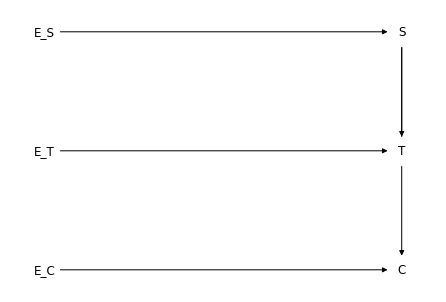

In [2]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['E_S', 'E_T', 'E_C', 'S', 'T', 'C',]
edges = [('E_S','S'), ('E_T','T'), ('E_C','C'), ('S','T'), ('S','C')]
nodes_pos = {'E_S':(-1, 1), 'S':(1, 1), 'E_T':(-1, -1), 'T':(1, -1), 'E_C':(-1, -3), 'C':(1, -3)}
nodes_lbl = {'E_S':'E_S', 'E_T':'E_T', 'E_C':'E_C', 'S':'S', 'T':'T', 'C':'C'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Our model captures a direct causal relationship between smoking and the formation of tar deposits, as well as a direct causal relationship betweeen tar deposits and the insurgence of lung cancer. The causal connection between smoking and cancer is thus mediated by tar deposits. Our model also represents variable factors beyond our model as independent exogenous variables.

### Simplified model

Performing a push-forward of the probability distributions on the exogenous nodes over the endogenous nodes, we can simplify the model and consider only the set of variables $\mathcal{X}$. We can then represent the same model $\mathcal{M}$ as:

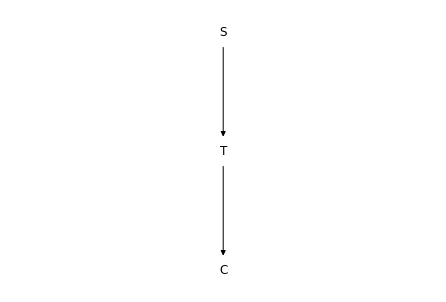

In [3]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['S', 'T', 'C',]
edges = [('S','T'), ('T','C')]
nodes_pos = {'S':(1, 1), 'T':(1, -1),  'C':(1, -3)}
nodes_lbl = {'S':'S', 'T':'T', 'C':'C'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

This new simplified model maintains the same basic structures of the previous complete PSCM, but it hides away the exogenous variables moving their stochastic contribution directly into the endogenous nodes.

Following the example in [Rischel2020], we then assume the following probability distributions over the respective endogenous variables:
- $P_{S} = \mathtt{Bern}(0.2)$
- $P_{T} = \mathtt{Bern}(0.8 \cdot S)$
- $P_{C} = \mathtt{Bern}(0.3 \cdot T + 0.1)$

where $\mathtt{Bern}(p)$ is a Bernoulli random variable with parameter $p$. Notice that only $P_{S}$ defines a *marginal distribution* $P_{\mathcal{M}}(S)$, while $P_{T}$ and $P_{C}$ are defined as *conditional distributions* $P_{\mathcal{M}}(T \vert S)$ and $P_{\mathcal{M}}(C \vert T)$. Reading our model as a Bayesian network, we have that the *joint distribution* of $\mathcal{M}$ is given by the product of these distributions:
$$
P_{\mathcal{M}}(S,T,C) = P_{\mathcal{M}}(S) P_{\mathcal{M}}(T \vert S) P_{\mathcal{M}}(C \vert T) = P_{S} P_{T} P_{C}.
$$

### Implementation

We can now implement the model as a simple class with two methods:
- *\__init__()*: setting up the parameters of the probability distributions of interest;
- *sample()*: returning a sample from the model.

In [4]:
class model0_pscm():
    def __init__(self,ps=.2):
        self.ps = ps
        
    def sample(self):
        S = scipy.random.binomial(1,self.ps)
        T = scipy.random.binomial(1,.8*S)
        C = scipy.random.binomial(1,.3*T+.1)
        
        return S,T,C

We instantiate model $\mathcal{M}$.

In [5]:
M0_pscm = model0_pscm()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [6]:
data0_pscm = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data0_pscm[i,:] = M0_pscm.sample()

100%|█████████████████████████████| 1000000/1000000 [00:04<00:00, 224815.84it/s]


To have a basic insight in the results, we plot the empirical marginal distributions of $C$, $T$ and $S$.

Empirical marginal distributions:
P(S=1) = 0.199486
P(T=1) = 0.159614
P(C=1) = 0.147555


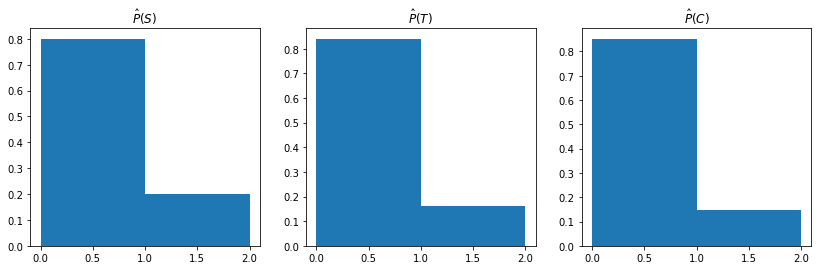

In [7]:
fig,ax = plt.subplots(1,3, figsize=(14,4))

ax[0].hist(data0_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[0].set_title('$\hat{P}(S)$')

ax[1].hist(data0_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[1].set_title('$\hat{P}(T)$')

ax[2].hist(data0_pscm[:,2],bins=np.array(list(range(3))),density=True)
ax[2].set_title('$\hat{P}(C)$')

print('Empirical marginal distributions:')
print('P(S=1) = {0}'.format(np.sum(data0_pscm[:,0])/n_samples))
print('P(T=1) = {0}'.format(np.sum(data0_pscm[:,1])/n_samples))
print('P(C=1) = {0}'.format(np.sum(data0_pscm[:,2])/n_samples))

## FinStoch M0

A category is a mathematical structure capturing relations of interest among objects.

### Model

A category is defined by *objects* and *morphisms* satisfying properties of composition, identity, and associativity. A PSCM with a finite number of variables defined on finite sets (as in the case of our example $\mathcal{M}$) may be modeled in the **monoidal category** $\mathtt{FinStoch}$ [Rischel2020,Fritz2020]. $\mathtt{FinStoch}$ is a category in which:
- *Objects* are finite sets;
- *Morphisms* are *stochastic matrices* or *Markov kernels* between sets;
- *Composition* is given by matrix multiplication;
- *Identity* is given by the identity matrix;
- *Associativity* is given by matrix multiplication associativity;
- *Monoidal product* is the Cartesian product of sets.

Following [Rischel2020], we use the operator $\mathcal{M}[]$ to express the PSCM in categorical terms.

Instead of considering the random variables $S, T, C$ we consider the following sets:
- $\mathcal{M}[S] = \{0,1\}$
- $\mathcal{M}[T] = \{0,1\}$
- $\mathcal{M}[C] = \{0,1\}$

Instead of considering the structural functions in our PSCM, we consider the following stochastic matrices:
- $\mathcal{M}[\phi_S] : \{*\} \rightarrow \mathcal{M}[S] = \left[\begin{array}{cc}
	.8 & .2
	\end{array}\right]$
- $\mathcal{M}[\phi_T] : \mathcal{M}[S] \rightarrow \mathcal{M}[T] = \left[\begin{array}{cc}
	1 & 0\\
	.2 & .8
	\end{array}\right]$
- $\mathcal{M}[\phi_C] : \mathcal{M}[T] \rightarrow \mathcal{M}[C] = \left[\begin{array}{cc}
	.9 & .1\\
	.6 & .4
	\end{array}\right]$

Notice how the probability distributions defined above get encoded in the stochastic matrices; in particular:
- $\mathcal{M}[\phi_S] = \left[\begin{array}{cc}
	.8 & .2
	\end{array}\right] = \left[\begin{array}{cc}
	P_{\mathcal{M}}(S=0) & P_{\mathcal{M}}(S=1)
	\end{array}\right]$ 
    encodes $P_{\mathcal{M}}(S)$ in the form of a mapping from the singleton set $\{*\}$ to the set $\mathcal{M}[S]$;
- $\mathcal{M}[\phi_T] = \left[\begin{array}{cc}
	1 & 0\\
	.2 & .8
	\end{array}\right] = \left[\begin{array}{cc}
	P_{\mathcal{M}}(T=0\vert S=0) & P_{\mathcal{M}}(T=1\vert S=0)\\
	P_{\mathcal{M}}(T=0\vert S=1) & P_{\mathcal{M}}(T=1\vert S=1)
	\end{array}\right]$ encodes $P_{\mathcal{M}}(T\vert S)$ in the form of a mapping from the set $\mathcal{M}[S]$ to the set $\mathcal{M}[T]$;
- and $\mathcal{M}[\phi_C] = \left[\begin{array}{cc}
	.9 & .1\\
	.6 & .4
	\end{array}\right] = \left[\begin{array}{cc}
	P_{\mathcal{M}}(C=0\vert T=0) & P_{\mathcal{M}}(C=1\vert T=0)\\
	P_{\mathcal{M}}(C=0\vert T=1) & P_{\mathcal{M}}(C=1\vert T=1)
	\end{array}\right]$ encodes $P_{\mathcal{M}}(C\vert T)$ in the form of a mapping from the set $\mathcal{M}[T]$ to the set $\mathcal{M}[C]$.
    
This encoding preserves the information necessary for expressing the joint distribution of our PSCM, read as a Bayesian network, as:
$$
    P_{\mathcal{M}}(S,T,C) = P_{\mathcal{M}}(C \vert T) P_{\mathcal{M}}(T \vert S) P_{\mathcal{M}}(S)
$$

Some observations:

**Phi-notation.** Notice that the $\phi$-nomenclature is meant to connect the stochastic matrices with the structural mechanism in the causal model, not with the edges or the type of probability distribution encoded; for instance, $\mathcal{M}[\phi_S]$ represents the mechanism $P_S$ in variable $S$ which is expressed by a *marginal* distribution, while $\mathcal{M}[\phi_T]$ and $\mathcal{M}[\phi_C]$ represent the mechanisms $P_T$ and $P_C$ in variables $T$ and $C$ which are expressed by *conditional* distributions.

**Multivariate extension.** While all our examples are univariate, the monoidal structure of $\mathtt{FinStoch}$ allows us to easily extend our formalism to multivariate cases using monoidal products. For instance, if we were working with a graph like $ S \rightarrow C \leftarrow T $, we would define $\mathcal{M}[\phi_C]: \mathcal{M}[S] \times \mathcal{M}[T] \rightarrow \mathcal{M}[C] = \{ (0,0), (0,1), (1,0), (1,1) \} \rightarrow \{ 0, 1 \}$ in the form of a $4 \times 2$ matrix.
Notice, again, that $\mathcal{M}[\phi_C]$ does not correspond to an edge in the graph representation of the model $\mathcal{M}$; it does not correspond to the edge $S \rightarrow C$ or the edge $C \leftarrow T$, but instead correspond to the mechanism that takes as input both $S$ and $T$ and produces $C$.

**Distributions.** In general, the formalism of $\mathtt{FinStoch}$ allows us to represent *univariate marginal distributions* as mappings from the singleton set to a set, for instance $P_{\mathcal{M}}(S): \{*\}\rightarrow \mathcal{M}[S]$. *Multivariate marginal distributions* or *joint distributions* are represented as mappings from the singleton set to a Cartesian product of sets, for instance $P_{\mathcal{M}}(S,T,C): \{*\}\rightarrow \mathcal{M}[S] \times \mathcal{M}[T] \times \mathcal{M}[C]$. Finally, *conditional distributions* are are represented as mappings from set to set, for instance $P_{\mathcal{M}}(T \vert S): \mathcal{M}[T] \rightarrow \mathcal{M}[S]$.

**Matrix multiplication.** Matrix multiplication corresponds to composition in $\mathtt{FinStoch}$:
$$
\mathcal{M}[\phi_T] \circ \mathcal{M}[\phi_S] = \mathcal{M}[\phi_S] \cdot \mathcal{M}[\phi_T]
$$
Pay attention that using the standard categorical operation of composition ($\circ$) reverses the order of matrix multiplication ($\cdot$). The result, is a new (marginalized) distribution, such as:
$$
\mathcal{M}[\phi_S]: \{*\} \rightarrow \mathcal{M}[S]\\
\mathcal{M}[\phi_T]: \mathcal{M}[S] \rightarrow \mathcal{M}[T]\\
\mathcal{M}[\phi_T] \circ \mathcal{M}[\phi_S]: \{*\} \rightarrow \mathcal{M}[T]
$$
In probabilistic terms the matrix multiplication has the following meaning:
$$
    \mathcal{M}[\phi_S] \cdot \mathcal{M}[\phi_T] = \sum_S P_{\mathcal{M}}(S) P_{\mathcal{M}}(T \vert S) = P_{\mathcal{M}}(T),
$$
which highlights the operation of marginalization (via the sum). Notice that the marginalization does not necessarily return a univariate marginal distribution, for instance:
$$
\mathcal{M}[\phi_T]: \mathcal{M}[S] \rightarrow \mathcal{M}[T]\\
\mathcal{M}[\phi_C]: \mathcal{M}[T] \rightarrow \mathcal{M}[C]\\
\mathcal{M}[\phi_C] \circ \mathcal{M}[\phi_T]: \mathcal{M}[S] \rightarrow \mathcal{M}[C]
$$
that is:
$$
    \mathcal{M}[\phi_T] \cdot \mathcal{M}[\phi_C] = \sum_T P_{\mathcal{M}}(T \vert S) P_{\mathcal{M}}(C \vert T) = P_{\mathcal{M}}(C \vert S),
$$
appealing to the independence $P_{\mathcal{M}}(C \vert T) = P_{\mathcal{M}}(C \vert T,S)$



**Element-wise multiplication.** Finally, element-wise multiplication may be used to compute new joint distributions of interest:
$$
    \mathcal{M}[\phi_S]^T \odot \mathcal{M}[\phi_T] = P_{\mathcal{M}}(S) P_{\mathcal{M}}(T \vert S) = P_{\mathcal{M}}(S,T).
$$

### Implementation

We now use the above formalism to re-implement our model as a simple class with three methods:
- *\__init__()*: setting up the stochastic matrices of interest;
- *sample()*: returning a sample from the model;
- *sample_C()*: directly sampling C by using matrix multiplication.

In [8]:
class model0_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiT = np.array([[1,0],[.2,.8]])
        self.MphiC = np.array([[.9,.1],[.6,.4]])
        
    def sample(self):
        S = scipy.random.binomial(1,self.MphiS[1])
        T = scipy.random.binomial(1,self.MphiT[S,1])
        C = scipy.random.binomial(1,self.MphiC[T,1])        
        return S,T,C
    
    def sample_C(self):
        p = np.dot(np.dot(self.MphiS,self.MphiT),self.MphiC)[1]
        return scipy.random.binomial(1, p)

We instantiate model $\mathcal{M}$ in this new form.

In [9]:
M0_finstoch = model0_finstoch()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples, using both the *sample()* method (returning all the intermediate random variables) and the *sample_C()* method (returning only the variable $C$ by computing its probability via multiplication of stochastic matrices).

In [10]:
data0_finstoch = np.zeros((n_samples,3))
data0_finstoch_C = np.zeros((n_samples,1))

for i in tqdm(range(n_samples)):
    data0_finstoch[i,:] = M0_finstoch.sample()
    data0_finstoch_C[i,:] = M0_finstoch.sample_C()

100%|█████████████████████████████| 1000000/1000000 [00:07<00:00, 129058.68it/s]


We now compare the empirical marginal distributions of $C$, $T$ and $S$ in the PSCM and the FinStoch implementation.

Empirical marginal distributions:
PSCM: P(S=1) =     0.199486
FinStoch: P(S=1) = 0.199968

PSCM: P(T=1) =     0.159614
FinStoch: P(T=1) = 0.1604

PSCM: P(C=1) =     0.147555
FinStoch: P(C=1) = 0.147711
FinStoch: P(C=1) = 0.147591


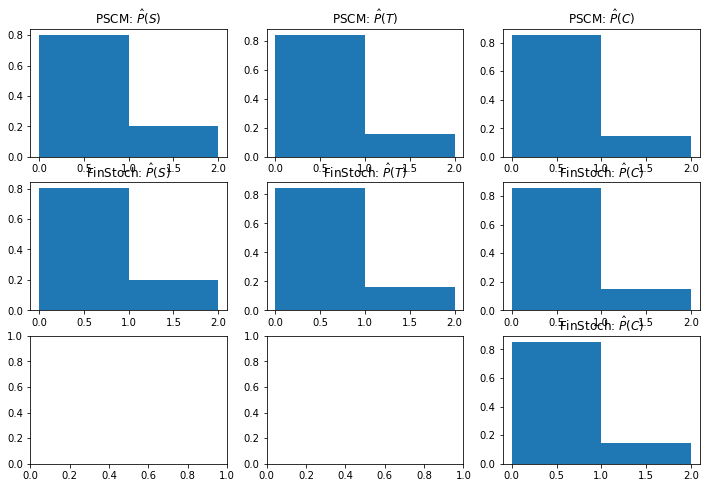

In [11]:
fig,ax = plt.subplots(3,3, figsize=(12,8))

ax[0,0].hist(data0_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('PSCM: $\hat{P}(S)$')

ax[0,1].hist(data0_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('PSCM: $\hat{P}(T)$')

ax[0,2].hist(data0_pscm[:,2],bins=np.array(list(range(3))),density=True)
ax[0,2].set_title('PSCM: $\hat{P}(C)$')

ax[1,0].hist(data0_finstoch[:,0],bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('FinStoch: $\hat{P}(S)$')

ax[1,1].hist(data0_finstoch[:,1],bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('FinStoch: $\hat{P}(T)$')

ax[1,2].hist(data0_finstoch[:,2],bins=np.array(list(range(3))),density=True)
ax[1,2].set_title('FinStoch: $\hat{P}(C)$')


ax[2,2].hist(data0_finstoch_C[:,0],bins=np.array(list(range(3))),density=True)
ax[2,2].set_title('FinStoch: $\hat{P}(C)$')

print('Empirical marginal distributions:')
print('PSCM: P(S=1) =     {0}'.format(np.sum(data0_pscm[:,0])/n_samples))
print('FinStoch: P(S=1) = {0}'.format(np.sum(data0_finstoch[:,0])/n_samples))

print('\nPSCM: P(T=1) =     {0}'.format(np.sum(data0_pscm[:,1])/n_samples))
print('FinStoch: P(T=1) = {0}'.format(np.sum(data0_finstoch[:,1])/n_samples))

print('\nPSCM: P(C=1) =     {0}'.format(np.sum(data0_pscm[:,2])/n_samples))
print('FinStoch: P(C=1) = {0}'.format(np.sum(data0_finstoch[:,2])/n_samples))
print('FinStoch: P(C=1) = {0}'.format(np.sum(data0_finstoch_C[:,0])/n_samples))

As expected, the distributions coincide.

## Recap

In this section we have seen that:

1. **We can express a causal model as a (complete) PSCM**: this requires defining exogenous variables, endogenous variables, structural functions, and probability distributions.

2. **We can express a causal model as a simplified PSCM**: this requires defining variables, and structural probability distributions.

3. **We can express a causal model in the $\mathtt{FinStoch}$ category**: this requires defining sets and stochastic matrices.


# A First Abstraction

In this section we observe how two models may be related in terms of abstraction.

We introduce a new model $\mathcal{M}'$, a simpler version of model $\mathcal{M}$. In the new model $\mathcal{M}'$ we restrict our attention only to two variables: smoking (S) and cancer (C).

We will sometime refer to the original model with more details as the *low-level* model, and the abstracted simplified model with less details as *high-level* model. This nomenclature comes from statistical physics were low-level models offer microscopic descriptions, while high-level models abstract into macroscopic descriptions. Notice that the definition of low-level and high-level is always relative; thus, in some cases $\mathcal{M'}$ may be high-level with respect to $\mathcal{M}$, but it may be low-level with respect to another model $\mathcal{M''}$.

## PSCM M1

### Model

We can express the complete PSCM for model $\mathcal{M}'$ as
- $\mathcal{E} = \{E_{S}, E_{C}\}$
- $\mathcal{X} = \{{S}, {C}\}$
- $\mathcal{F} = \{f_{S}(E_{S}), f_{C}({S},E_{C}))\}$
- $\mathcal{P} = \{P_{E_{S}}, P_{E_{C}}\}$

The simplified model (hiding the exogenous variables and pushing forward the distributions) can be visualized with the following DAG:

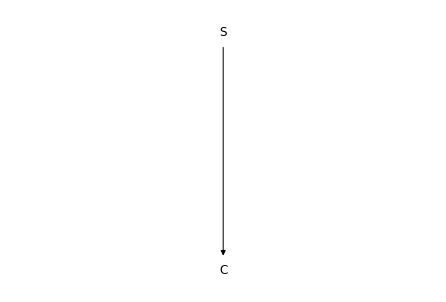

In [12]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['S', 'C',]
edges = [('S','C')]
nodes_pos = {'S':(1, 1), 'C':(1, -1)}
nodes_lbl = {'S':'S', 'C':'C'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The new simplified model abstracts away the mediator node $T$, preserving only $S$ and $C$ and connecting them directly. In this new model, smoking is directly causally connected to the insurgence of cancer. 

The decision of suppressing a variable like $T$ may be due to many possible reasons, such as the emergence of a new theoretical model or the lack of reliable data for the variable. 

Following the example in [Rischel2020], we then assume the following probability distributions:
- $P_{S} = \mathtt{Bern}(0.2)$
- $P_{C} = \mathtt{Bern}(0.24 \cdot S + 0.1)$

The distribution on $P_{S}$ is then unchanged between $\mathcal{M}$ and $\mathcal{M}'$, while the distribution on $P_{C}$ is reshaped, likely to match the observed data.

### Implementation

We can now implement the model $\mathcal{M}'$ as we did before:

In [13]:
class model1_pscm():
    def __init__(self,ps=.2):
        self.ps = ps
        
    def sample(self):
        S = scipy.random.binomial(1,self.ps)
        C = scipy.random.binomial(1,.24*S+.1)
        
        return S,C

We instantiate model $\mathcal{M}'$.

In [14]:
M1_pscm = model1_pscm()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [15]:
data1_pscm = np.zeros((n_samples,2))

for i in tqdm(range(n_samples)):
    data1_pscm[i,:] = M1_pscm.sample()

100%|█████████████████████████████| 1000000/1000000 [00:03<00:00, 322651.53it/s]


## FinStoch M1

### Model

As before, we express our model $\mathcal{M}'$ as a structure in $\mathtt{FinStoch}$ .

The random variables $S, C$ are represented as sets:
- $\mathcal{M}'[S] = \{0,1\}$
- $\mathcal{M}'[C] = \{0,1\}$

And the mechanisms are expressed through stochastic matrices:
- $\mathcal{M}'[\phi_S] : \{*\} \rightarrow \mathcal{M}'[S] = \left[\begin{array}{cc}
	.8 & .2
	\end{array}\right]$
- $\mathcal{M}'[\phi_C] : \mathcal{M}'[S] \rightarrow \mathcal{M}'[C] = \left[\begin{array}{cc}
	.9 & .1\\
	.66 & .34
	\end{array}\right]$
    
The meaning and interpretation of these stochastic matrices is the same as for the model $\mathcal{M}$.

### Implementation

We now re-implement our model according to the above formalism:

In [16]:
class model1_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiC = np.array([[.9,.1],[.66,.34]])
        
    def sample(self):
        S = scipy.random.binomial(1,self.MphiS[1])
        C = scipy.random.binomial(1,self.MphiC[S,1])        
        return S,C
    
    def sample_C(self):
        p = np.dot(self.MphiS,self.MphiC)[1]
        return scipy.random.binomial(1, p)

We instantiate model $\mathcal{M}'$.

In [17]:
M1_finstoch = model1_finstoch()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples, using both the *sample()* method (returning all the intermediate random variables) and the *sample_C()* method (returning only the variable $C$ by computing its probability via multiplication of stochastic matrices).

In [18]:
data1_finstoch = np.zeros((n_samples,2))
data1_finstoch_C = np.zeros((n_samples,1))

for i in tqdm(range(n_samples)):
    data1_finstoch[i,:] = M1_finstoch.sample()
    data1_finstoch_C[i,:] = M1_finstoch.sample_C()

100%|█████████████████████████████| 1000000/1000000 [00:05<00:00, 181488.80it/s]


## Comparing models

We now want to look at the two models $\mathcal{M}$ and $\mathcal{M}'$ and try to assess how compatible they are with respect to their behaviours. 

In general, a basic intuition is that probability distributions encode the behaviour of a model. Then, if $\mathcal{M}'$ is supposed to work as an abstraction of $\mathcal{M}$, we would expect it to encode similar distributions to $\mathcal{M}$. It seems then to be a natural approach to evaluate the models comparing their distributions. Yet, **which distributions should we look at?**

### Observational distributions

Let us first think about *observational distributions*. 

**Marginal distributions.** The marginal distributions of individual random variables describes the behaviour of random variables in isolation. Just looking at these quantities presents some problems.
- (*mismatched variables*) A first issue is that two models $\mathcal{M}$ and $\mathcal{M}'$ may be defined on different variables. In our case, for instance, we can not reasonably compare the distribution $P_\mathcal{M}(T)$ with any distribution in $\mathcal{M'}$. The absence of a variable in the abstracted model $\mathcal{M'}$ suggests that such a variable is deemed unimportant, and therefore it may make sense to ignore its distribution.
- (*mismatched domain*) A second problem is that individual variables may be defined over different domain. This is not the case in our example, but we may easily imagine a detailed model $\mathcal{M}$ in which the smoking variable is not binary, but discretized according to the smoking habit of a patient. In such an instance, a direct comparison of $P_\mathcal{M}(S)$ and $P_\mathcal{M'}(S)$ is impossible, unless some alignment between the domains is provided.
- (*isolated behaviour*) The marginal distribution of a variable captures only the behaviour in isolation, and does not provide information about the behaviour of the variable jointly with other variables (i.e., we miss the copula). Suppose, for instance, that $P_\mathcal{M}(S) = P_\mathcal{M'}(S) = \mathtt{Bern}(0.5)$, but $P_\mathcal{M}(C) = S$ and $P_\mathcal{M'}(C) = -S$; marginal distributions in the two models are identical, although the conditional and the joints are different.

In the formalism of $\mathtt{FinStoch}$ comparing two marginals is equivalent to compare whether two (1-row) stochastic matrices, for instance $\mathcal{M}[\phi_C*]: \{*\} \rightarrow \mathcal{M}[C]$ and $\mathcal{M'}[\phi_C*]: \{*\} \rightarrow \mathcal{M'}[C]$, are equal. Notice that $\mathcal{M'}[\phi_C*] = \mathcal{M'}[\phi_S] \cdot \mathcal{M'}[\phi_C]$, and that, for a given $\mathcal{M'}[\phi_C*]$ and $\mathcal{M'}[\phi_S]$ the stochastic matrix $\mathcal{M'}[\phi_C]$ is not necessarily unique, re-iterating that the same marginal distributions may be combined through different conditionals. Repeating the example above, if $\mathcal{M'}[\phi_C*] = \mathcal{M'}[\phi_S] = \left[\begin{array}{cc}
		.5 & .5
	\end{array}\right] $, then $\mathcal{M'}[\phi_C] = \left[\begin{array}{cc}
	1 & 0\\
	0 & 1
	\end{array}\right]$ or $\mathcal{M'}[\phi_C] = \left[\begin{array}{cc}
	0 & 1\\
	1 & 0
	\end{array}\right]$.
    
Observing marginal distributions thus provides limited information. Agreement does not guarantee that the models behave in the same way, although strong disagreement could suggest that the models are quite far apart.

**Conditional distributions.** Conditional distributions allow us to observe the behaviour of certain variables conditioned on others. Since a PSCM is defined by a DAG with a specific *factorization* carrying a causal semantics, we restrict our attention to the conditional distributions entailed by such a factorization. Again some observations are in order.
- (*mismatched variables*) We can compare conditionals in the two models $\mathcal{M}$ and $\mathcal{M}'$ only with respect to common variables. Thus we can not compare $P_\mathcal{M}(C \vert T)$ as the variable $T$ is not available in $\mathcal{M}'$. Moreover, comparing some variables may require some manipulation; for instance $P_\mathcal{M'}(C \vert S)$ may be compared to $P_\mathcal{M}(C \vert S) = \sum_T P_\mathcal{M}(C \vert T) P_\mathcal{M}(T \vert S)$.
- (*mismatched domains*) Mismatched domains require alignment.
- (*conditional behaviour*) As the marginal distribution captures the behaviour only in isolation, so the conditional captures the behaviour only in conditioning. Identical conditional distributions do not guarantee that the marginal distributions in the root nodes of the DAG will be identical.

In the formalism of $\mathtt{FinStoch}$ comparing two conditionals is equivalent to compare whether two stochastic matrices connecting two sets are equal.

Observing identical conditional distributions means that the observational causal mechanisms between two variables (or sets of variables) are the same. Agreement suggests that, in an observational domain, the underlying mechanisms have statistically the same behaviour; however, the same marginal distribution over the root nodes of the DAG is required in order to observe an identical behaviour.

**Joint distribution.** The marginal distributions of the root variables of the DAG and the conditional distributions defined by the factorization of the DAG completely specify the joint distribution of a causal model. For instance, $P_{\mathcal{M}}(S,T,C) = P_{\mathcal{M}}(C \vert T) P_{\mathcal{M}}(T \vert S) P_{\mathcal{M}}(S)$ and $P_{\mathcal{M'}}(S,C) = P_{\mathcal{M'}}(C \vert S) P_{\mathcal{M'}}(S)$. Again we have the same issues we defined above.
- (*mismatched variables*) As models may be defined on different variables, the joint distributions must be compared with reference to the abstracted model. In our case, for instance, we can only compare $P_\mathcal{M'}(S,C)$ and $P_\mathcal{M}(S,C) = \sum_T P_\mathcal{M}(S,T,C)$.
- (*mismatched domains*) Mismatched domains require alignment.

Equivalence of joint distributions may be assessed by the evaluation of the relevant marginals and conditionals, and it would guarantee a compatible observational behavior.

### Interventional distributions

Overall equality between observational distributions guarantee that, if we observe the behaviours of the models with respect to the variables of interest considered, we would end up with compatible observations.

However, observational equality does not take into consideration the possibility of **interventions** in the model. By intervention we mean the possibility for an external experimenter to set the value of a random variable (or node) to a chosen value $do(X=x)$. Such an operation affects the dynamics of the model $\mathcal{M}$, effectively producing a new model called *intervened model* $\mathcal{M}_{do(X=x)}$ [Pearl2009,Peters2017].

Interventions are particularly important in the context of abstracting causal models, as often causal models are used as tools not only to observe a given phenomenon, but also to affect and control the same phenomenon. Whenever we abstract the causal model $\mathcal{M}$ to a causal model $\mathcal{M'}$ we are not interested only in the question "*will the observations from the new high-level model $\mathcal{M'}$ be compatible with the observations from the low-level model $\mathcal{M}$?*", but also (and perhaps more importantly) "*if I were to act on the new high-level model $\mathcal{M'}$ will I observe the same results as as if I were to make interventions on the low-level model $\mathcal{M}$?*". Indeed compatibility under interventions is an important aspects in evaluating abstraction between causal models [Rubenstein2017].

For the moment we will limit ourselves to comparing our models from an observational perspective, and we will come back to the interventional perspective later.

## Comparison of M0 and M1

We now want to look at the two models $\mathcal{M}$ and $\mathcal{M}'$ and try to assess how compatible they are considering the different *observational distributions* we discussed above. 

### Marginal distributions

We start by observing the empirical marginal distributions of our random variables in $\mathcal{M}$ and $\mathcal{M}'$, computed both with the PSCM and the FinStoch models.

Empirical marginal distributions:
PSCMs:
M0: P(S=1) =     0.199486
M1: P(S=1) = 0.199181

M0: P(T=1) =     0.159614

M0: P(C=1) =     0.147555
M1: P(C=1) = 0.147834


FinStochs:
M0: P(S=1) =     0.199968
M1: P(S=1) = 0.200136

M0: P(T=1) =     0.1604

M0: P(C=1) =     0.147711
M1: P(C=1) = 0.148185


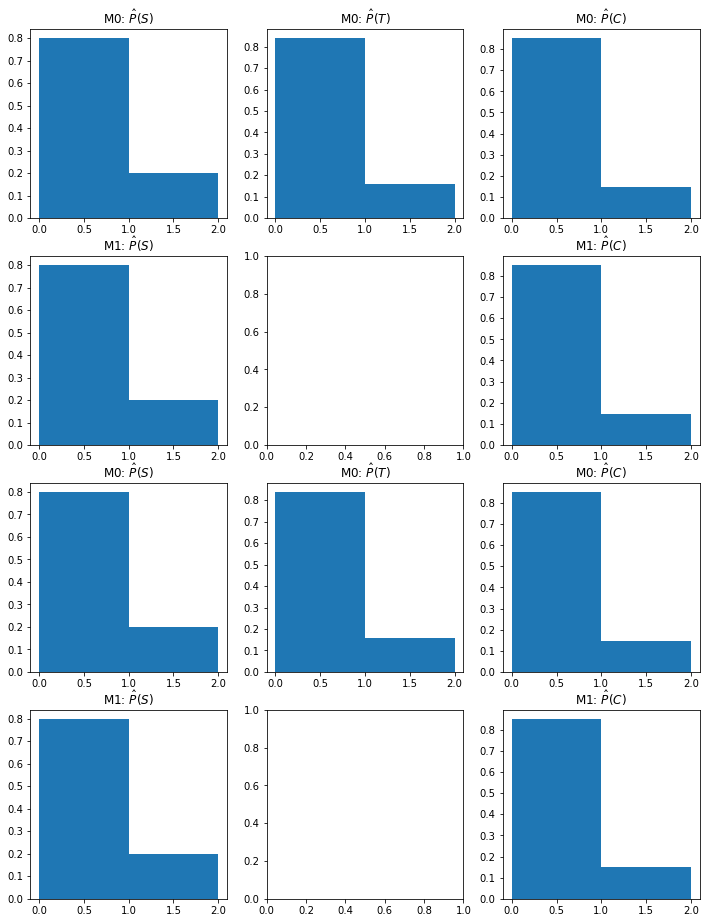

In [19]:
fig,ax = plt.subplots(4,3, figsize=(12,16))

ax[0,0].hist(data0_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('M0: $\hat{P}(S)$')

ax[0,1].hist(data0_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('M0: $\hat{P}(T)$')

ax[0,2].hist(data0_pscm[:,2],bins=np.array(list(range(3))),density=True)
ax[0,2].set_title('M0: $\hat{P}(C)$')

ax[1,0].hist(data1_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('M1: $\hat{P}(S)$')

ax[1,2].hist(data1_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[1,2].set_title('M1: $\hat{P}(C)$')

ax[2,0].hist(data0_finstoch[:,0],bins=np.array(list(range(3))),density=True)
ax[2,0].set_title('M0: $\hat{P}(S)$')

ax[2,1].hist(data0_finstoch[:,1],bins=np.array(list(range(3))),density=True)
ax[2,1].set_title('M0: $\hat{P}(T)$')

ax[2,2].hist(data0_finstoch[:,2],bins=np.array(list(range(3))),density=True)
ax[2,2].set_title('M0: $\hat{P}(C)$')

ax[3,0].hist(data1_finstoch[:,0],bins=np.array(list(range(3))),density=True)
ax[3,0].set_title('M1: $\hat{P}(S)$')

ax[3,2].hist(data1_finstoch[:,1],bins=np.array(list(range(3))),density=True)
ax[3,2].set_title('M1: $\hat{P}(C)$')

print('Empirical marginal distributions:')
print('PSCMs:')
print('M0: P(S=1) =     {0}'.format(np.sum(data0_pscm[:,0])/n_samples))
print('M1: P(S=1) = {0}'.format(np.sum(data1_pscm[:,0])/n_samples))

print('\nM0: P(T=1) =     {0}'.format(np.sum(data0_pscm[:,1])/n_samples))

print('\nM0: P(C=1) =     {0}'.format(np.sum(data0_pscm[:,2])/n_samples))
print('M1: P(C=1) = {0}'.format(np.sum(data1_pscm[:,1])/n_samples))

print('\n\nFinStochs:')
print('M0: P(S=1) =     {0}'.format(np.sum(data0_finstoch[:,0])/n_samples))
print('M1: P(S=1) = {0}'.format(np.sum(data1_finstoch[:,0])/n_samples))

print('\nM0: P(T=1) =     {0}'.format(np.sum(data0_finstoch[:,1])/n_samples))

print('\nM0: P(C=1) =     {0}'.format(np.sum(data0_finstoch[:,2])/n_samples))
print('M1: P(C=1) = {0}'.format(np.sum(data1_finstoch[:,1])/n_samples))


The empirical marginal distributions over the relevant variables $S$ and $C$ seem to agree. After all, the distributions over $S$ were defined in the same way, while the distributions over $C$ can be shown to be equivalent.

In particular, using matrix multiplication in the $\mathtt{FinStoch}$ formalism, it is easy to show that the composition $\mathcal{M}[\phi_C] \circ \mathcal{M}[\phi_T] \circ \mathcal{M}[\phi_S]$ is equal to the composition $\mathcal{M}'[\phi_C] \circ \mathcal{M}'[\phi_S]$:

In [20]:
np.dot(np.dot(M0_finstoch.MphiS,M0_finstoch.MphiT),M0_finstoch.MphiC)

array([0.852, 0.148])

In [21]:
np.dot(M1_finstoch.MphiS,M1_finstoch.MphiC)

array([0.852, 0.148])

This is not surprising, as the probability distributions in $\mathcal{M}'$ were cooked up on purpose to match with those in $\mathcal{M}$. Some form of compatibility may thus exist.

### Conditional distributions

We can move on to evaluate how variables relate to each other. To do so, we observe the empirical conditional distributions in the two models, with respect to the only variables available in $\mathcal{M}'$, that is $S$ and $C$.

Empirical condiitional distributions:
M0: P(C=1|S=0) = 0.09955476780928763
M1: P(C=1|S=0) = 0.1004870828040767

M0: P(C=1|S=1) = 0.34037445991358617
M1: P(C=1|S=1) = 0.33881460606787384


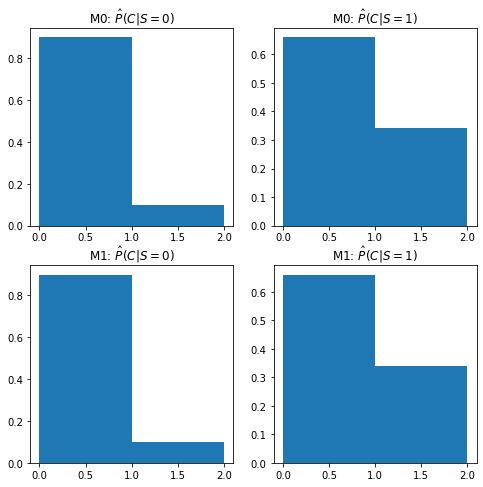

In [22]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

data0_CgivenS0 = data0_finstoch[data0_finstoch[:,0]==0,2]
data0_CgivenS1 = data0_finstoch[data0_finstoch[:,0]==1,2]

data1_CgivenS0 = data1_finstoch[data1_finstoch[:,0]==0,1]
data1_CgivenS1 = data1_finstoch[data1_finstoch[:,0]==1,1]

ax[0,0].hist(data0_CgivenS0,bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('M0: $\hat{P}(C|S=0)$')

ax[0,1].hist(data0_CgivenS1,bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('M0: $\hat{P}(C|S=1)$')

ax[1,0].hist(data1_CgivenS0,bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('M1: $\hat{P}(C|S=0)$')

ax[1,1].hist(data1_CgivenS1,bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('M1: $\hat{P}(C|S=1)$')

print('Empirical condiitional distributions:')
print('M0: P(C=1|S=0) = {0}'.format(np.sum(data0_CgivenS0)/data0_CgivenS0.size))
print('M1: P(C=1|S=0) = {0}'.format(np.sum(data1_CgivenS0)/data1_CgivenS0.size))

print('\nM0: P(C=1|S=1) = {0}'.format(np.sum(data0_CgivenS1)/data0_CgivenS1.size))
print('M1: P(C=1|S=1) = {0}'.format(np.sum(data1_CgivenS1)/data1_CgivenS1.size))

Once again, the empirical conditional distributions seem to agree; notice that they indeed match the values that we previously entered in the stochastic matrix $\mathcal{M}'[\phi_C]$ which indeed is meant to encode $P_\mathcal{M'}(C \vert S)$.

### Joint distributions

Finally, since we are working with just two variables ($S,C$) with binary ouptuts, we can easily get a complete view of the behaviour of the models by estimating the empirical joint distributions.

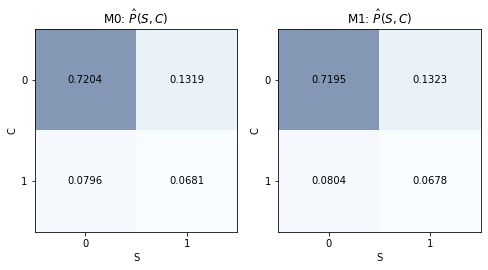

In [23]:
fig,ax = plt.subplots(1,2, figsize=(8,4))

SC00 = np.sum(np.logical_and(data0_finstoch[:,0]==0,data0_finstoch[:,2]==0)) / n_samples
SC01 = np.sum(np.logical_and(data0_finstoch[:,0]==0,data0_finstoch[:,2]==1)) / n_samples
SC10 = np.sum(np.logical_and(data0_finstoch[:,0]==1,data0_finstoch[:,2]==0)) / n_samples
SC11 = np.sum(np.logical_and(data0_finstoch[:,0]==1,data0_finstoch[:,2]==1)) / n_samples
M0_pSC = np.array([[SC00,SC10],[SC01,SC11]])

ax[0].matshow(M0_pSC,cmap='blue_alpha')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].set_xlabel('S')
ax[0].set_ylabel('C')
ax[0].set_title('M0: $\hat{P}(S,C)$')

for (i, j), z in np.ndenumerate(M0_pSC):
    ax[0].text(j, i, '{:0.4f}'.format(z), ha='center', va='center')
    
SC00 = np.sum(np.logical_and(data1_finstoch[:,0]==0,data1_finstoch[:,1]==0)) / n_samples
SC01 = np.sum(np.logical_and(data1_finstoch[:,0]==0,data1_finstoch[:,1]==1)) / n_samples
SC10 = np.sum(np.logical_and(data1_finstoch[:,0]==1,data1_finstoch[:,1]==0)) / n_samples
SC11 = np.sum(np.logical_and(data1_finstoch[:,0]==1,data1_finstoch[:,1]==1)) / n_samples
M1_pSC = np.array([[SC00,SC10],[SC01,SC11]])

ax[1].matshow(M1_pSC,cmap='blue_alpha')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].set_xlabel('S')
ax[1].set_ylabel('C')
ax[1].set_title('M1: $\hat{P}(S,C)$')

for (i, j), z in np.ndenumerate(M1_pSC):
    ax[1].text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

The two joint distributions $P_{\mathcal{M}}(S,C)$ and $P_{\mathcal{M}'}(S,C)$ closely match. Using element-wise multiplication in the $\mathtt{FinStoch}$ formalism, it is easy, especially in the case of $\mathcal{M}'$, to compute the joint $P_{\mathcal{M}'}(S,C)$ as $\mathcal{M'}[\phi_S]^T \odot \mathcal{M'}[\phi_C]$:

In [24]:
M1_finstoch.MphiS.reshape(2,1) * M1_finstoch.MphiC

array([[0.72 , 0.08 ],
       [0.132, 0.068]])

which corresponds to our numerical results, with the off-diagonal values swapped. The same result may be computed in $\mathcal{M}$ via the element-wise multiplication of $\mathcal{M}[\phi_S], \mathcal{M}[\phi_T]$ and $\mathcal{M}[\phi_C]$, although it would require some matrix manipulation to handle the distribution over $\mathcal{M}[S] \times \mathcal{M}[T]$.

Agreement between the joint distributions is not surprising since the the two models already agreed on the marginals and the conditionals defining the factorization of the models.

### Limits of the comparison

We have explored the possibility of comparing models related by abstraction by evaluating some distributions of interest. In particular, we showed agreement between our two models $\mathcal{M}$ and $\mathcal{M}'$, although our result holds *only* with respect to the variables $S$ and $C$ we examined. Clearly, we could not compare the two models with respect to the distribution of the variable $T$: if we were interesting in the variable $T$ the abstraction offered by $\mathcal{M}'$ would not serve our purpose. Complex causal models may be constituted by many variables; this would require us to define a criterion to choose with respect to which distributions and which variables we want to evaluate our abstraction.

Moreover, so far, we have only worked and compared *observational distributions*, and ignored *interventional distributions*, which, as discussed, are particularly relevant when discussing the consistency of abstracted models [Rubenstein2017].

## Recap

In this section, we have seen that:

1. **We may have models that we want to relate through abstraction**: some models may represent the same phenomenon at different levels of granularity/abstraction.

2. **We discussed how we could compare the behaviour of models at different levels of abstraction considering observational and interventional distributions over variables of interest**: intuitively a good abstraction would preserves the same behaviour over variables of interest in terms of observational and inteventional distributions.

3. **We compared models only with respect to observational distributions**: we observed how marginal, conditional and joint distributions are related in $\mathcal{M}$ and $\mathcal{M}'$ (with respect to $S$ and $C$).

4. **We limited our analysis to few observational distributions**: a good comparison of causal models should take into consideration interventional distributions as well.

# A Second Abstraction

In this section we consider another step of abstraction. We introduce a new model and perform a qualitative analysis of the observational distributions similar to what we have done before.

We make a further, more aggressive, simplification and define the model $\mathcal{M}''$. We retain the same two variables, but we now simplify their causal structure.

## PSCM M2

### Model

We can express the complete PSCM for model $\mathcal{M}''$ as
- $\mathcal{E} = \{E_{S}, E_{C}\}$
- $\mathcal{X} = \{{S}, {C}\}$
- $\mathcal{F} = \{f_{S}(E_{S}), f_{C}(E_{C}))\}$
- $\mathcal{P} = \{P_{E_{S}}, P_{E_{C}}\}$

The simplified model (hiding the exogenous variables and pushing forward the distributions) can be visualized with the following DAG:

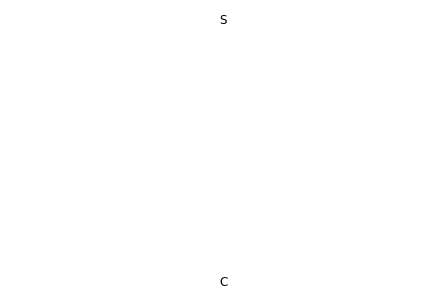

In [25]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['S', 'C',]
edges = []
nodes_pos = {'S':(1, 1), 'C':(1, -1)}
nodes_lbl = {'S':'S', 'C':'C'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The new simplified model removes the link between $S$ and $C$, thus asserting the causal independence of smoking and cancer. 

The decision and justification for such a remodellling would lie again with the modeller.

Following the example in [Rischel2020], we then assume the following probability distributions:
- $P_{S} = \mathtt{Bern}(0.2)$
- $P_{C} = \mathtt{Bern}(0.148)$

### Implementation

We can now implement the model $\mathcal{M}''$ as we did before:

In [26]:
class model2_pscm():
    def __init__(self,ps=.2):
        self.ps = ps
        
    def sample(self):
        S = scipy.random.binomial(1,self.ps)
        C = scipy.random.binomial(1,.148)
        
        return S,C

We instantiate model $\mathcal{M}''$.

In [27]:
M2_pscm = model2_pscm()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [28]:
data2_pscm = np.zeros((n_samples,2))

for i in tqdm(range(n_samples)):
    data2_pscm[i,:] = M2_pscm.sample()

100%|█████████████████████████████| 1000000/1000000 [00:03<00:00, 332416.31it/s]


## FinStoch M2

### Model

As before, we express our model $\mathcal{M}''$ as a structure in $\mathtt{FinStoch}$ .

The random variables $S, C$ are represented as sets:
- $\mathcal{M}[S] = \{0,1\}$
- $\mathcal{M}[C] = \{0,1\}$

And the mechanisms are expressed through stochastic matrices:
- $\mathcal{M}[\phi_S] : {*} \rightarrow \mathcal{M}[S] = \left[\begin{array}{cc}
	.8 & .2
	\end{array}\right]$
- $\mathcal{M}[\phi_C] : {*} \rightarrow \mathcal{M}[C] = \left[\begin{array}{cc}
	.852 & .148
	\end{array}\right]$
    
Notice now that both stochastic matrices express marginal distributions.

### Implementation

We now re-implement our model according to the above formalism:

In [29]:
class model2_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiC = np.array([.852,.148])
        
    def sample(self):
        S = scipy.random.binomial(1,self.MphiS[1])
        C = scipy.random.binomial(1,self.MphiC[1])        
        return S,C

We instantiate model $\mathcal{M}''$.

In [30]:
M2_finstoch = model2_finstoch()

### Simulation

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [31]:
data2_finstoch = np.zeros((n_samples,2))

for i in tqdm(range(n_samples)):
    data2_finstoch[i,:] = M2_finstoch.sample()

100%|█████████████████████████████| 1000000/1000000 [00:03<00:00, 309568.75it/s]


## Comparison of M1 and M2

As before, in order to get a first qualitative appreciation of the abstraction between models $\mathcal{M}'$ and $\mathcal{M}''$, we analyze their *observational distributions*.

### Marginal distributions

We start from the simple empirical marginal distributions of the random variables in $\mathcal{M}'$ and $\mathcal{M}''$, computed both with the PSCM and the $\mathtt{FinStoch}$ models.

Empirical marginal distributions:
PSCMs:
M1: P(S=1) =     0.199181
M2: P(S=1) = 0.200635

M1: P(C=1) =     0.147834
M2: P(C=1) = 0.147684


FinStochs:
M1: P(S=1) =     0.200136
M2: P(S=1) = 0.200606

M1: P(C=1) =     0.148185
M2: P(C=1) = 0.147389


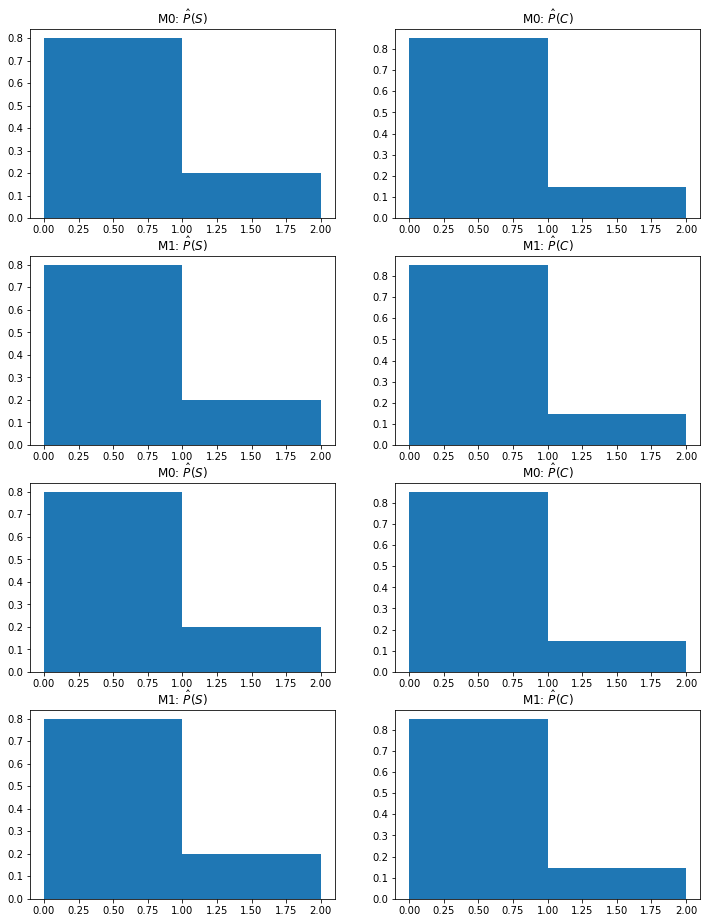

In [32]:
fig,ax = plt.subplots(4,2, figsize=(12,16))

ax[0,0].hist(data1_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('M0: $\hat{P}(S)$')

ax[0,1].hist(data1_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('M0: $\hat{P}(C)$')

ax[1,0].hist(data2_pscm[:,0],bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('M1: $\hat{P}(S)$')

ax[1,1].hist(data2_pscm[:,1],bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('M1: $\hat{P}(C)$')

ax[2,0].hist(data1_finstoch[:,0],bins=np.array(list(range(3))),density=True)
ax[2,0].set_title('M0: $\hat{P}(S)$')

ax[2,1].hist(data1_finstoch[:,1],bins=np.array(list(range(3))),density=True)
ax[2,1].set_title('M0: $\hat{P}(C)$')

ax[3,0].hist(data2_finstoch[:,0],bins=np.array(list(range(3))),density=True)
ax[3,0].set_title('M1: $\hat{P}(S)$')

ax[3,1].hist(data2_finstoch[:,1],bins=np.array(list(range(3))),density=True)
ax[3,1].set_title('M1: $\hat{P}(C)$')

print('Empirical marginal distributions:')
print('PSCMs:')
print('M1: P(S=1) =     {0}'.format(np.sum(data1_pscm[:,0])/n_samples))
print('M2: P(S=1) = {0}'.format(np.sum(data2_pscm[:,0])/n_samples))

print('\nM1: P(C=1) =     {0}'.format(np.sum(data1_pscm[:,1])/n_samples))
print('M2: P(C=1) = {0}'.format(np.sum(data2_pscm[:,1])/n_samples))

print('\n\nFinStochs:')
print('M1: P(S=1) =     {0}'.format(np.sum(data1_finstoch[:,0])/n_samples))
print('M2: P(S=1) = {0}'.format(np.sum(data2_finstoch[:,0])/n_samples))

print('\nM1: P(C=1) =     {0}'.format(np.sum(data1_finstoch[:,1])/n_samples))
print('M2: P(C=1) = {0}'.format(np.sum(data2_finstoch[:,1])/n_samples))

The empirical marginal distributions over the relevant variable $S$ and $C$ seem to agree. This makes sense once again because the distribution over $S$ is unchanged, and computing the composition $\mathcal{M}'[\phi_C] \circ \mathcal{M}'[\phi_S]$ via matrix multiplication we can observe that it is equal to $\mathcal{M}''[\phi_C]$:

In [33]:
np.dot(M1_finstoch.MphiS,M1_finstoch.MphiC)

array([0.852, 0.148])

In [34]:
M2_finstoch.MphiC

array([0.852, 0.148])

### Conditional distributions

We move to observe the empirical conditional probabilities of interest on the two models $\mathcal{M}'$ and $\mathcal{M}''$:

Empirical conditional distributions:
M1: P(C=1|S=0) = 0.1004870828040767
M2: P(C=1|S=0) = 0.14729032241923257

M1: P(C=1|S=1) = 0.33881460606787384
M2: P(C=1|S=1) = 0.14778221987378243


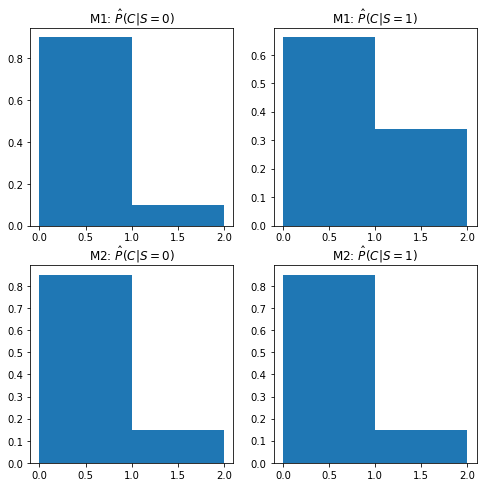

In [35]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

data2_CgivenS0 = data2_finstoch[data2_finstoch[:,0]==0,1]
data2_CgivenS1 = data2_finstoch[data2_finstoch[:,0]==1,1]

ax[0,0].hist(data1_CgivenS0,bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('M1: $\hat{P}(C|S=0)$')

ax[0,1].hist(data1_CgivenS1,bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('M1: $\hat{P}(C|S=1)$')

ax[1,0].hist(data2_CgivenS0,bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('M2: $\hat{P}(C|S=0)$')

ax[1,1].hist(data2_CgivenS1,bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('M2: $\hat{P}(C|S=1)$')

print('Empirical conditional distributions:')
print('M1: P(C=1|S=0) = {0}'.format(np.sum(data1_CgivenS0)/data1_CgivenS0.size))
print('M2: P(C=1|S=0) = {0}'.format(np.sum(data2_CgivenS0)/data2_CgivenS0.size))

print('\nM1: P(C=1|S=1) = {0}'.format(np.sum(data1_CgivenS1)/data1_CgivenS1.size))
print('M2: P(C=1|S=1) = {0}'.format(np.sum(data2_CgivenS1)/data2_CgivenS1.size))

We now notice a clear difference in the empirical conditional distributions in $\mathcal{M}'$ and $\mathcal{M}''$. In particular, in $\mathcal{M}''$, given the independence $S \perp C$, we have $$P_{\mathcal{M}''}(C \vert S=0) = P_{\mathcal{M}''}(C \vert S=1) = P_{\mathcal{M}''}(C),$$ while in $\mathcal{M}'$ the causal link between $S$ and $C$ guarantees that $$P_{\mathcal{M}'}(C \vert S=0) \neq P_{\mathcal{M}'}(C \vert S=1)$$.

### Joint distributions

Finally, we get a more complete view of the distributions of $S$ and $C$ in our two models by estimating their empirical joint distributions.

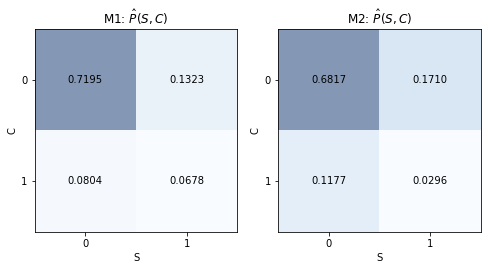

In [36]:
fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].matshow(M1_pSC,cmap='blue_alpha')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].set_xlabel('S')
ax[0].set_ylabel('C')
ax[0].set_title('M1: $\hat{P}(S,C)$')

for (i, j), z in np.ndenumerate(M1_pSC):
    ax[0].text(j, i, '{:0.4f}'.format(z), ha='center', va='center')
    
SC00 = np.sum(np.logical_and(data2_finstoch[:,0]==0,data2_finstoch[:,1]==0)) / n_samples
SC01 = np.sum(np.logical_and(data2_finstoch[:,0]==0,data2_finstoch[:,1]==1)) / n_samples
SC10 = np.sum(np.logical_and(data2_finstoch[:,0]==1,data2_finstoch[:,1]==0)) / n_samples
SC11 = np.sum(np.logical_and(data2_finstoch[:,0]==1,data2_finstoch[:,1]==1)) / n_samples
M2_pSC = np.array([[SC00,SC10],[SC01,SC11]])

ax[1].matshow(M2_pSC,cmap='blue_alpha')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].set_xlabel('S')
ax[1].set_ylabel('C')
ax[1].set_title('M2: $\hat{P}(S,C)$')

for (i, j), z in np.ndenumerate(M2_pSC):
    ax[1].text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

As expected, the two joint distributions are different: $$P_{\mathcal{M}'}(S,C) \neq P_{\mathcal{M}''}(S,C)$$

### Limits of the comparison

Our evaluation of abstraction between our two models $\mathcal{M}'$ and $\mathcal{M}''$ is always limited *only* to the distributions over the variables $S$ and $C$ of interest. We do not consider other observational distributions (which, in this case, are not available) nor interventional distributions.

## Limits in observational comparison

Our exploratory analysis focused on observational distributions has provided us with some basic insights on the behaviour of an abstracted model with reference to a base model. However, this approach had some limitations. 
1. First of all, the approach above was highly informal: it considered some variables of interest and compared few relevant distributions, but it did not provide a framework to assess the abstraction when comparing multiple sets of variables or how to quantify disagreement.
2. More importantly, our whole analysis was restricted to observational distributions. Recall, though, that the joint distribution of a causal model is not sufficient to evaluate interventions; knowledge of the structure of the DAG (or, equivalently, the factorization of the joint) is necessary to perform and solve interventions. Now, whenever we compare distributions in a low-level model $\mathcal{M}$ with a high-level model $\mathcal{M'}$ we end up marginalizing over certain variables; such an operation loses information relevant in the interventional domain which is available in the model $\mathcal{M}$; therefore, even if the observational distributions were to match, conclusions about the behaviour under interventions would not be guaranteed.

## Recap

In this section, we have seen that:

1. **Abstractions may have different degrees of approximation or quality**: some abstractions may exactly preserve the observational joint probability over variables of interest (like the abstraction from $\mathcal{M}$ to $\mathcal{M}'$), while others may distort the observational joint probability over variables of interest (like the abstraction from $\mathcal{M}'$ to $\mathcal{M}''$).

2. **Evaluating observational distributions provide only a limited perspective on the abstraction**: interventions are important in a causal context and studying only observational distributions does not allow us to decide how an abstracted model would behave under intervention.

# Formalizing Abstraction

The qualitative analysis performed in the previous sections gave us a flavor of the problem of relating models at different levels of abstraction. Now, in this section, we try to formalize the idea of abstraction.

## Abstracting in FinMod

Let us try to express the relationship between $\mathcal{M}$ and $\mathcal{M}'$ more rigorously. In particular, we want to express it as a relationship of **abstraction** from $\mathcal{M}$ to $\mathcal{M}'$.

To formalize this idea, let us now consider the category $\mathtt{FinMod}$ in which:

- *Objects* are finite stochastic models;
- *Morphisms* are abstractions of models;
- *Composition* is given by the concatenation of abstractions;
- *Identity* is given by a null abstraction;
- *Associativity* follows trivially.

Notice that while we used $\mathtt{FinStoch}$ to define an individual causal model $\mathcal{M}$ (objects were variables/set and morphisms were mechanisms/stochastic matrices), we now use $\mathtt{FinMod}$ to define a universe of causal models (objects are models and morphisms are abstractions).

At low level (i.e., with refernce to $\mathtt{FinStoch}$) an abstraction from $\mathcal{M}$ to $\mathcal{M}'$ is defined as follows:
1. A subset $R \subseteq \mathcal{X}_\mathcal{M}$ of relevant (endogenous) variables of $\mathcal{M}$
2. A surjective map $a: R \rightarrow \mathcal{X}_{\mathcal{M}'}$ mapping the relevant (endogenous) variables of $\mathcal{M}$ to the (endogenous) variables of $\mathcal{M}'$ surjectively, so that all the (endogenous) variables in $\mathcal{M}'$ have a pre-image in $\mathcal{M}$;
3. $\forall X \in \mathcal{X}_{\mathcal{M}'}$, a surjective function $\alpha: \mathcal{M}[a^{-1}(X)] \rightarrow \mathcal{M}'[X]$; that is, for every variable $X$ in $\mathcal{M}'$ with associated set $\mathcal{M}'[X]$, there is a surjective mapping from the set $\mathcal{M}[a^{-1}(X)]$ associated with the pre-image of $X$ in $\mathcal{M}$ along $a$. In other words, any outcome of the variable $X$ in $\mathcal{M}'$ is reachable from the pre-image of variables picked in $\mathcal{M}$ by $a$.

(**TODO:** prove compositionality of abstractions thus defined. Identity and associativity seem trivial.)

## Abstraction from M0 to M1

Using the definition of abstraction above, let use define an abstraction from the model $\mathcal{M}$ we have considered to the higher-level model $\mathcal{M}'$.

We will define our abstraction as follows:
1. $R=\{ S, C \}$: we consider as relevant variables in $\mathcal{M}$ only $S$ and $C$.
2. $a(S)=S, a(C)=C$: we map the variables in $\mathcal{M}$ to the variables with the same name in $\mathcal{M}'$.
3. $\alpha_S: \mathcal{M}[S] \rightarrow \mathcal{M}'[S] = id, \alpha_C: \mathcal{M}[C] \rightarrow \mathcal{M}'[C] = id$: we have two functions mapping the sets $\mathcal{M}[S] = \mathcal{M}[C] = \{0,1\}$ to $\mathcal{M}'[S] = \mathcal{M}'[C] = \{0,1\}$ via identity mappings.

Notice that our definition of abstraction defines how the variables of two models $\mathcal{M}$ and $\mathcal{M}'$, and their underlying sets, are related, but it does not make explicit requests on the structural functions or stochastic matrices.

## Abstraction from M1 to M2

Similarly, using the definition of abstraction given above, we can specify an abstraction from the model $\mathcal{M}'$ to the higher-level model $\mathcal{M}''$ as follows:
1. $R=\{ S, C \}$: we consider as relevant variables in $\mathcal{M}'$ all the variables.
2. $a(S)=S, a(C)=C$: we map the variables in $\mathcal{M}'$ to the variables with the same name in $\mathcal{M}''$.
3. $\alpha'_S: \mathcal{M'}[S] \rightarrow \mathcal{M}''[S] = id, \alpha'_C: \mathcal{M}'[C] \rightarrow \mathcal{M}''[C] = id$: we have two functions mapping the sets $\mathcal{M}'[S] = \mathcal{M}'[C] = \{0,1\}$ to $\mathcal{M}''[S] = \mathcal{M}''[C] = \{0,1\}$ via identity mappings.

## Recap

In this section, we have seen that:

1. **We can express causal models in the $\mathtt{FinMod}$ category**: a single object in this category is now a whole causal model.

2. **Morphisms in $\mathtt{FinMod}$ may express abstraction**: an abstraction captures a mapping between variables and their underlying sets; an abstraction does not explicitly constrain stochastic matrices.

3. **Abstraction may be defined wrt to $\mathtt{FinStoch}$**: an abstraction may be defined in terms of mapping between variables and their underlying sets.

4. **Our example abstractions may be expressed in this formalism**: the two abstractions we considered, from $\mathcal{M}$ to $\mathcal{M'}$, and from $\mathcal{M'}$ to $\mathcal{M''}$, can be re-expressed in categorical terms.

# Evaluating the Abstraction

Having provided a formal encoding of abstraction, in this section we consider how we could evaluate the quality of the abstraction in a categorical framework.

## Abstraction in FinStoch

**Causal models.**
Let $\mathcal{M}$ and $\mathcal{M}'$ be two generic causal models (not necessarily the ones in the examples above). As discussed above, we have two perspectives:
- we can see the two models as objects of $\mathtt{FinMod}$,
- or, we can represent these causal models in the category $\mathtt{FinStoch}$.

**Abstraction.**
Let us now consider an abstraction $\alpha$ from $\mathcal{M}$ to $\mathcal{M}'$. Consistently with the two pespectives above:
- in $\mathtt{FinMod}$ the abstraction is a morphism $\alpha: \mathcal{M} \rightarrow \mathcal{M}'$;
- in $\mathtt{FinStoch}$, given two (sets of) variables $S$ and $C$ in $\mathcal{M}'$, the abstraction induces the following diagram:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[\alpha^{-1}\left(S\right)\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{\alpha^{-1}\left(C\right)}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[\alpha^{-1}\left(C\right)\right]\\
\sideset{}{\alpha}\downarrow &  & \sideset{}{\alpha}\downarrow\\
\mathcal{\mathcal{M}}'\left[S\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[C\right]
\end{array}
$$

## Abstraction diagram

Let us examine the diagram above. Two obvious but important points before proceeding:
- The diagram lives in $\mathtt{FinStoch}$;
- The diagram does not necessarily commute.

In order to understand the meaning of the diagram, let us read it out with reference to our running example:
- The lower half of the diagram represents two variables of interest in $\mathcal{M}'$: it depicts the set $\mathcal{M}'[S]$ associated with $S$, the set $\mathcal{M}'[C]$ associated with $C$, and the stochastic matrix $\mathcal{M}'[\phi_C]$ between them.
- Similarly, the upper half represents the variables of interest in $\mathcal{M}$. First, we have the set $\mathcal{M}[\alpha^{-1}(S)]$ which represents the set of values that are mapped by the abstraction $\alpha$ onto the set of variable $S$ in $\mathcal{M}'$; notice that set $\mathcal{M}[\alpha^{-1}(S)]$ may be the set of values assumed by a single random variable (as in our case) or by a product of random variables (a Cartesian product of sets). Next, we have the set $\mathcal{M}[\alpha^{-1}(C)]$. Last, we have the stochastic matrix relating the two sets.
- Finally, the upper half and lower half are then connected by the abstraction $\alpha$.

In the specific case of our example, we can simplify our diagram as follows:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[S\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M}}'\left[S\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[C\right]
\end{array}
$$
where 
we substituted $\mathcal{M}[\alpha^{-1}(S)]$ and $\mathcal{M}[\alpha^{-1}(C)]$ with the simple pre-images $\mathcal{M}[S]$ and $\mathcal{M}[C]$, 
we substituted $\mathcal{M}\left[\phi_{\alpha^{-1}\left(C\right)}\right]$ with the stochastic matrix $\mathcal{M}\left[\phi_{\bar{C}}\right]$ given by the composition of the map from $S$ to $T$ and the map from $T$ to $C$,
and we specified the abstraction on the relevant variables as $\alpha_S$ and $\alpha_C$.

Since the diagram lives in $\mathtt{FinStoch}$, $\alpha_S$ and $\alpha_C$ must be morphisms in the category, that is, they must be stochastic matrices. Since both mappings amount to identities, they may be expressed as $\alpha_S = \alpha_C = \left[\begin{array}{cc}
	1 & 0\\
	0 & 1
	\end{array}\right].$

## Commutativity of the abstraction diagram

As stated, the abstraction diagram is not guaranteed to commute; however, let us examine what it would mean if the diagram were to commute, once again with reference to our example.

If the diagram were to commute, the following two routes on the diagram would be equivalent:
$$
\alpha_C \circ \mathcal{M}[\phi_\bar{C}] = \mathcal{M}'[\phi_C] \circ \alpha_S,
$$
that is, starting from the set for the variable $S$ in $\mathcal{M}$ it would be equivalent to:
- map first to the set of the variable $C$ in $\mathcal{M}$ via the stochastic matrix $\mathcal{M}[\phi_\bar{C}]$, and then abstract to the variable $C$ in $\mathcal{M}'$ via the stochastic matrix $\alpha_C$;
- abstract first to the variable $S$ in $\mathcal{M}'$ via the stochastic matrix $\alpha_S$, and then map to the set of the variable $C$ in $\mathcal{M}'$ via the stochastic matrix $\mathcal{M}'[\phi_C]$.

This would constitute a *good* abstraction (at least, with respect to the variables considered), in the sense that stochastic mechanisms and abstractions would commute. 

## Meaning of commutativity

Assuming the commutativity of the diagram in $\mathtt{FinStoch}$, **what exactly does it mean that we have a good abstraction? Or, more precisely, what can we exactly conclude by the fact that abstractions and mechanisms commute? What can we state with the more familiar lexicon of probability?**

**Caveat**. Let us start with a negative example. It may be tempting (it was for me, at least) to read the above diagram in a probabilistic perspective, something like:
$$
\begin{array}{ccc}
P_{\mathcal{M}}(S) & \overset{\phi}{\longrightarrow} & P_{\mathcal{M}}(C \vert S)\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
P_{\mathcal{M'}}(S) & \overset{\phi'}{\longrightarrow} & P_{\mathcal{M'}}(C \vert S)\\
\end{array},
$$
where $\phi$ is a function encoding the causal mechanism. This translation is not correct, though. Remember that in $\mathtt{FinStoch}$ objects are sets and morphisms are stochastic matrices encoding distributions. In the probabilistic diagram above objects have been converted to probability distributions and morphisms to mechanisms or abstractions. An immediate difference is that the original diagram in $\mathtt{FinStoch}$ has no notion of the marginal distributions $P_{\mathcal{M}}(S)$ or $P_{\mathcal{M'}}(S)$, but it just considers the sets over which distributions are defined.

**Observational distributions.** A consequence of the above caveat is that an abstraction $\alpha: \mathcal{M} \rightarrow \mathcal{M'}$ between two models may entail a commuting diagram over a root endogenous variable and another endogenous variable, and yet there may be different marginal distributions over the root variables in $\mathcal{M}$ and $\mathcal{M'}$. Despite commutativity we may then obtain a different observational behavior when we run the two models.

**Non-identity of conditionals** Moreover, notice how, by the same definition of the abstraction diagram in $\mathtt{FinStoch}$, commutativity does not imply an identity of conditional distributions. Conditional distributions are encoded in the stochastic matrices $\mathcal{M}[\phi_\bar{C}]$ and $\mathcal{M}'[\phi_C]$. Commutativity implies an equality when these stochastic matrices are composed with abstractions: $\alpha_C \circ \mathcal{M}[\phi_\bar{C}] = \mathcal{M}'[\phi_C] \circ \alpha_S$. Assuming that the conditional distributions are comparable in the two models, there are only rare cases (such as our case in which $\alpha_C = \alpha_S = id$) when commutativity implies identity of conditional distributions.

**Interpretation.** Commutativity thus seems not to necessarily entail identity over marginal, conditional, or, by consequence, joint distribution. What exactly does it capture? The commuting diagram is meant to capture interventional identity: if we were intervene on node $S$, then working on $\mathcal{M}$ or $\mathcal{M'}$ would produce the same result. More precisely, assume that we perform an intervention on $S$; then it is equivalent:
- use first a mechanism at low level to map $S$ to $C$ via the stochastic matrix $\mathcal{M}[\phi_\bar{C}]$, and then abstract to the variable $C$ in the high-level model $\mathcal{M}'$;
- abstract first to the variable $S$ in the high-level model $\mathcal{M}'$, and then use the mechanism at high level to map $S$ to $C$ via the stochastic matrix $\mathcal{M}'[\phi_C]$.
Notice how, by intervening on $S$, the marginal on this variable becomes irrelevant.

To sum up, given two generic (sets of) variables $S,C \in \mathcal{X}_\mathcal{M'}$ the commutativity of the following diagram 
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[S\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M}}'\left[S\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[C\right]
\end{array}
$$
means that, under intervention, abstracting-sampling and sampling-abstracting is (statistically) equivalent (where by sampling we mean sampling from the mechanism). The composition of stochastic matrices (one for a conditional distribution and one for the abstraction) return the same stochastic matrix.

**Commutativity in case of a singleton set.** As a limit case, it is possible to select as the first set a singleton; we would then get the following diagram
$$
\begin{array}{ccc}
\{*\} & \overset{\mathcal{\mathcal{M}}\left[\phi_{\bar{S}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[S\right]\\
\sideset{}{id}\downarrow &  & \sideset{}{\alpha_{S}}\downarrow\\
\{*\} & \overset{\mathcal{\mathcal{M}}'\left[\phi_{S}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[S\right]
\end{array}
$$
where on the left we have two singleton sets trivially related by an identity morphism. As before, commutativity would mean that, under intervention, abstracting-sampling and sampling-abstracting produce the same (statistical) results. Commutativity in this case is concerned with a marginal distribution instead of a conditional one. Indeed, it tells us that the composition of stochastic matrices along the upper path (one for the marginal distribution of $S$ in the base model and one for the abstraction of $S$) produces the same stochastic matrix as the stochastic matrix for the marginal distribution of $S$ in the abstracted model (in the lower path we have a composition of an identity and the marginal distribution).

Notice, however, that in this case the meaning of *under intervention* is trivial. There is no intervention on the singleton set but the null-intervention.

## Interventional consistency

The interpretation above explains how commutativity is aimed at evaluating at assessing consistency (commutativity) *intervention*. Although the standard formulation of the commuting diagram in [Rischel2020] has the form:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[S\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M}}'\left[S\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[C\right]
\end{array}
$$

a better formulation that explicitly accounts for intervention would be:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}_{do(S=s)}}\left[S\right] & \overset{\mathcal{\mathcal{M}_{do(S=s)}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}_{do(S=s)}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M'}}_{do(a(S)=\alpha_S(s))}\left[S\right] & \overset{\mathcal{\mathcal{M'}}_{do(a(S)=\alpha_S(s))}\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M'}}_{do(a(S)=\alpha_S(s))}\left[C\right]
\end{array}
$$
The notation is heavier but it underlines that, at the low level, we are considering the intervention $do(S=s)$ and we are therefore working on the model $\mathcal{M}_{do(S=s)}$. Consequently, at the high level, we will consider the intervention $do(a(S)=\alpha_S(s))$ induced by the mappings $a$ and $\alpha_S$, which means working on the model $\mathcal{M'}_{do(a(S)=\alpha_S(s))}$.

For simplicity, we will just use the $do$ notation, leaving the arguments implicit as they can be immediately deduced from the diagram. We will specify the arguments only in case they will not be obvious.
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}_{do}}\left[S\right] & \overset{\mathcal{\mathcal{M}_{do}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}_{do}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M'}}_{do}\left[S\right] & \overset{\mathcal{\mathcal{M'}}_{do}\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M'}}_{do}\left[C\right]
\end{array}
$$

## Commutativity from M0 and M1

Let us check whether commutativity holds when considering the abstraction $\alpha: \mathcal{M} \rightarrow \mathcal{M}'$ in our example. We have the already discussed diagram:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}_{do}}\left[S\right] & \overset{\mathcal{\mathcal{M}_{do}}\left[\phi_{\bar{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}_{do}}\left[C\right]\\
\sideset{}{\alpha_{S}}\downarrow &  & \sideset{}{\alpha_{C}}\downarrow\\
\mathcal{\mathcal{M'}_{do}}\left[S\right] & \overset{\mathcal{\mathcal{M'}_{do}}\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M'}_{do}}\left[C\right]
\end{array}
$$

Notice that, in this particular case, performing an intervention on $\mathcal{M}$ or $\mathcal{M'}$ does not change the underlying DAG of our SCMs, since the node $S$ in $\mathcal{M}$ and $\mathcal{M'}$ has no incoming nodes.

We want to evalute if:
$$
\alpha_C \circ \mathcal{M}_{do}[\phi_\bar{C}] = \mathcal{M'}_{do}[\phi_C] \circ \alpha_S.
$$
First we substitute $\mathcal{M}_{do}[\phi_\bar{C}]$ with its explicit components:
$$
\alpha_C \circ \left( \mathcal{M}_{do}[\phi_{C}] \circ \mathcal{M}_{do}[\phi_{T}] \right) = \mathcal{M'}_{do}[\phi_C] \circ \alpha_S,
$$
with round brackets added just for readability. Inserting the numbers (and reverting the order):
$$
\left(
\left[\begin{array}{cc}
1 & 0\\
.2 & .8
\end{array}\right]
\cdot
\left[\begin{array}{cc}
.9 & .1\\
.6 & .4
\end{array}\right]
\right)
\cdot
\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
=    
\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
\cdot
\left[\begin{array}{cc}
.9 & .1\\
.66 & .34
\end{array}\right]
$$

In [37]:
alpha = np.array([[1,0],[0,1]])

first = np.dot(np.dot(M0_finstoch.MphiT, M0_finstoch.MphiC), alpha)
second = np.dot(alpha, M1_finstoch.MphiC)
print(first)
print(second)

[[0.9  0.1 ]
 [0.66 0.34]]
[[0.9  0.1 ]
 [0.66 0.34]]


The results are identical, confirming that our abstraction diagram commutes.

This should not come as a surprise. Given that our abstractions are identities, our computation boiled down to compare conditonal distributions $P(C \vert S)$, which we had previosly shown to be identical. It is worth to remark, though, that having abstractions equal to identities is a special case; in general, verification of commutativity is not the same as verification of identity of conditionals.

Commutativity now implies that if we act on the variable $S$ by setting it to $s$, abstraction and mechanism commute. We can then:
- compute $P_\mathcal{M}(C\vert do(S=s))$ using the mechanism at low level $\mathcal{M}$ and then abstract via $\alpha_C$;
- abstract via $\alpha_S$ and then compute $P_\mathcal{M'}(C\vert do(S=\alpha_S(s)))$ using the mechanism at high level $\mathcal{M}'$;

and we would obtain the same result.

## Commutativity from M1 and M2

Let us carry out the same analysis for the second abstraction, that is $\alpha': \mathcal{M'} \rightarrow \mathcal{M}''$. The current diagram is:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M'}_{do}}\left[S\right] & \overset{\mathcal{\mathcal{M'}_{do}}\left[\phi_{{C}}\right]}{\longrightarrow} & \mathcal{\mathcal{M'}_{do}}\left[C\right]\\
\sideset{}{\alpha'_{S}}\downarrow &  & \sideset{}{\alpha'_{C}}\downarrow\\
\mathcal{\mathcal{M''}}_{do}\left[S\right] & \overset{\mathcal{\mathcal{M''}}_{do}\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M''}}_{do}\left[C\right]
\end{array}
$$

In this case, too, acting on $S$ does not affect the structure of the DAG of $\mathcal{M'}$ and $\mathcal{M''}$.

We want to evalute if:
$$
\alpha'_C \circ \mathcal{M'}_{do}[\phi_{C}] = \mathcal{M''}_{do}[\phi_C] \circ \alpha'_S,
$$
where $\alpha'_C$ and $\alpha'_S$ are still identity matrices.

Inserting the numbers (and reverting the order):
$$
\left[\begin{array}{cc}
.9 & .1\\
.66 & .34
\end{array}\right]
\cdot
\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
=    
\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
\cdot
\left[\begin{array}{cc}
.852 & .148\\
.852 & .148
\end{array}\right]
\cdot
$$

Notice that $\mathcal{M''}_{do}[\phi_C] = \left[\begin{array}{cc}
.852 & .148
\end{array}\right]$ has shape $1 \times 2$ because in $\mathcal{M}''$ the variable $S$ and $C$ are independent and thus $P_{\mathcal{M}''}(C \vert S) = P_{\mathcal{M}''}(C)$; to explicitly (and redundantly) express the conditional $P_{\mathcal{M}''}(C \vert S)$ in a $2 \times 2$ matrix we duplicate the row.

In [38]:
alpha = np.array([[1,0],[0,1]])

first = np.dot(M1_finstoch.MphiC,alpha)
second = np.dot(alpha,np.vstack((M2_finstoch.MphiC,M2_finstoch.MphiC)))
print(first)
print(second)

[[0.9  0.1 ]
 [0.66 0.34]]
[[0.852 0.148]
 [0.852 0.148]]


The results are different implying that the abstraction diagram does not commute.

Again, since in this specific case abstractions are identities, commutativity equals identity of conditionals, and we have already noticed that the conditonal distributions $P(C \vert S)$ differs in $\mathcal{M}'$ and $\mathcal{M}''$.

Non-commutativity now implies that if act on the variable $S$ by setting it to $s$, abstraction and mechanism do not commute. If we:
- compute $P_\mathcal{M'}(C\vert do(S=s))$ using the mechanism at low level $\mathcal{M'}$ and then abstract via $\alpha'_C$;
- abstract via $\alpha'_S$ and then compute $P_\mathcal{M''}(C\vert do(a(S)=\alpha'_S(s)))$ using the mechanism at high level $\mathcal{M}''$;

we would not be guaranteed to obtain the same result.

## Recap

In this section, we have seen that:

1. **Abstractions may be expressed as diagrams in $\mathtt{FinStoch}$**: we can express how abstraction affects the relationship between variables of interest considering diagrams containing abstraction morphisms and mechanism morphisms.

2. **Commutativity of the diagram in $\mathtt{FinStoch}$ means that, under intervention, abstraction and mechanisms may commute**: commutativity of the diagram is not related to observational distributions, but to interventional distributions.

2. **Our example abstractions may or may not guarantee commutativity**: our first abstraction from $\mathcal{M}$ and $\mathcal{M}'$ makes the abstraction diagram commute with respect to $S$ and $C$, while our second abstraction from $\mathcal{M}'$ and $\mathcal{M}''$ does not.

# Measuring the Abstraction Approximation

Having realistically to deal with abstractions that may lose some (causal) information, in this section we consider how we could measure the change or the approximation introduced by an abstraction.

## Abastraction Approximation in FinStoch

As we have seen above, an abstraction can induce a diagram in $\mathtt{FinStoch}$ which does not commute. We thus want to compute some *difference* or *distance* between the two paths we can take on the diagram, thus quantifying the difference between (i) using a mechanism and then abstracting, and (ii) abstracting and then using a mechanism. To do this formally, we will move to work in an *enriched category*.

## Enriched FinStoch

An enriched category is a category endowed with some form of structure over its morphims. 

The category $\mathtt{FinStoch}$ may be enriched in the category $\mathtt{Met}$ [Milewski2008]. We can define the **enriched category** $\mathtt{Met}$-$\mathtt{FinStoch}$ [Rischel2020] in which:
- *Objects* are finite sets;
- Pairs of objects form *hom-objects* with the structure of a metric space.

With reference to our case we have the following model.

**Objects**. Objects are the sets we already worked with: $$\mathcal{M}[S]= \{0,1\}, \quad \mathcal{M}[T]= \{0,1\}, \quad \mathcal{M}[C]= \{0,1\}.$$

**Hom-objects**. Hom-objects are sets, as well, such as: 
$$\mathtt{FinStoch}(\mathcal{M}[S],\mathcal{M}[S]), \quad \mathtt{FinStoch}(\mathcal{M}[S], \mathcal{M}[T]), \quad \mathtt{FinStoch}(\mathcal{M}[T],\mathcal{M}[S]), \quad \mathtt{FinStoch}(\mathcal{M}[S],\mathcal{M}[C])...$$
The notation is suggestive of hom-sets because these hom-objects are indeed sets of morphisms between objects.

**Metric space over hom-objests**. Each hom-object form a metric space, such as:
$$(\mathtt{FinStoch}(\mathcal{M}[S],\mathcal{M}[T]), d_{JSD})$$ 
where the set is the hom-set of stochastic matrices:
$$\mathcal{M}[\phi_T]: \mathcal{M}[S] \rightarrow \mathcal{M}[T],$$ 
and distance given by Jensen-Shannon distance:
$$d_{JSD} (\mathcal{M}[\phi_T],\mathcal{M}[\phi_T']) = \sup_{s \in \mathcal{M}[S]} \left( \sqrt{ JSD(\mathcal{M}[\phi_T],\mathcal{M}[\phi_T']) } \right),$$ 
where JSD is the Jensen-Shannon divergence.

The choice of the Jensen-Shannon distance is due to its symmetry and triangle inequality, which allow us to guarantee compositionality (see Remark 4.20 in [Rischel2020]). KL divergence does not satisfy triangle inequality, while Wasserstein metrics could be adopted although they would require a choice of a specific metric (see Remark 4.20 in [Rischel2020]).

**Composition of hom-objects**. Composition of hom-objects is given by 
$$\circ: \mathtt{FinStoch}(\mathcal{M}[S],\mathcal{M}[T]) \times \mathtt{FinStoch}(\mathcal{M}[T],\mathcal{M}[C]) \rightarrow \mathtt{FinStoch}(\mathcal{M}[S],\mathcal{M}[C])$$
and is short in each variable:
$$ d_{JSD} (\mathcal{M}[\phi_C] \circ \mathcal{M}[\phi_T], \mathcal{M}[\phi_C] \circ \mathcal{M}[\phi_T']) \leq d_{JSD} (\mathcal{M}[\phi_T], \mathcal{M}[\phi_T'])$$
$$ d_{JSD} (\mathcal{M}[\phi_C] \circ \mathcal{M}[\phi_T], \mathcal{M}[\phi_C'] \circ \mathcal{M}[\phi_T]) \leq d_{JSD} (\mathcal{M}[\phi_C], \mathcal{M}[\phi_C'])$$

(**TODO:** discuss the monoidal product of hom-objects)

## Measuring Abastraction Approximation in Met-FinStoch

We can now exploit the enriched structure of $\mathtt{Met}$-$\mathtt{FinStoch}$ to measure the distance between the two paths, in terms of the distance we have adopted ($d_{JSD}$).

Given our diagram which now lives in $\mathtt{Met}$-$\mathtt{FinStoch}$:
$$
\begin{array}{ccc}
\mathcal{\mathcal{M}_{do}}\left[\alpha^{-1}\left(S\right)\right] & \overset{\mathcal{\mathcal{M}_{do}}\left[\phi_{\alpha^{-1}\left(C\right)}\right]}{\longrightarrow} & \mathcal{\mathcal{M}_{do}}\left[\alpha^{-1}\left(C\right)\right]\\
\sideset{}{\alpha_S}\downarrow &  & \sideset{}{\alpha_C}\downarrow\\
\mathcal{\mathcal{M'}_{do}}\left[S\right] & \overset{\mathcal{\mathcal{M'}_{do}}\left[\phi_{C}\right]}{\longrightarrow} & \mathcal{\mathcal{M'}_{do}}\left[C\right]
\end{array}
$$
we can compute the distance, or error $E_\alpha(S,C)$ of abstraction $\alpha$ between the variables of interest $S$ and $C$, as:
$$
E_\alpha(S,C) = \sup_{s \in \mathcal{M}[S]} \left( d_{JSD} \left( \alpha_C \circ {\mathcal{M}_{do}}\left[\phi_{\alpha^{-1}\left(C\right)}\right] , \mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S \right) \right)
$$
$$
E_\alpha(S,C) = \sup_{s \in \mathcal{M}[S]} \left( \sqrt{ JSD \left( \alpha_C \circ {\mathcal{M}_{do}}\left[\phi_{\alpha^{-1}\left(C\right)}\right] , \mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S \right)} \right)
$$
where $\alpha_C \circ {\mathcal{M}_{do}}\left[\phi_{\alpha^{-1}\left(C\right)}\right]$ constitute the upper part of the diagram, and $\mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S$ the lower part. Notice that taking the $\sup_{s \in \mathcal{M}[S]}$ may be read as computing the distance $d_{JSD}$ for all possible interventions, and choosing the greatest.

While $E_\alpha(S,C)$ is meant to quantify the abstraction error over two individual variables, we can get a more generic measure of the *overall* abstraction error $e(\alpha)$ by simply taking the supremum of the abstraction error over all possible disjoint pairs of variables:
$$
e(\alpha) = \sup_{X,X' \in \mathcal{X}_\mathcal{M'_{do}}} E_\alpha(X,X')
$$

## Meaning of Abstraction Error

When we measure the abstraction error on a non-commutating diagram we *take* an element in the outcome set of $P_{\mathcal{M}}(S)$, and evaluate how distant apart are the results of abstracting-sampling and sampling-abstracting. Arbitrarily *taking* an element in the outcome set $P_{\mathcal{M}}(S)$ ignores the sampling probability of the element (if $S$ is a root variable) or the mechanistic generating probability (if $S$ is not a root variable). This operation is then analogous to an *intervention* in which the value of the variable $S$ is arbitrarily set independently of its own mechanism.

The meaning of abstraction error is then to measure the distance between the two *interventional distributions* generated by following the two possibly non-commuting paths on the diagram. $E_\alpha(S,C)$ is the worst-case distance in the interventional distributions defined by the two variables $S$ and $C$. $e_\alpha$ is the worst-case distance considering all possible pairs of variables.

**Zero-error approximation**. For an abstraction that has an overall abstraction error of zero $e_\alpha=0$, this means that, for any (sets of) variables $S,C \in \mathcal{X}_{\mathcal{M'}}$, if we were to intervene on the variable(s) in the pre-image $\alpha^{-1}_S(S)$, abstracting-sampling and sampling-abstracting would produce the same (statistical) results. Thus, if we were to be concerned with such an intervention, it would be the same (after intervening) to run the model and abstract, or to abstract and run the model.

With respect to this interpretation, it may be debatable whether we should consider diagrams such as:
$$
\begin{array}{ccc}
\{*\} & \overset{\mathcal{\mathcal{M}}\left[\phi_{\bar{S}}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[S\right]\\
\sideset{}{id}\downarrow &  & \sideset{}{\alpha_{S}}\downarrow\\
\{*\} & \overset{\mathcal{\mathcal{M}}'\left[\phi_{S}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[S\right]
\end{array}
$$
Here, the particular approximation error $E_\alpha(\{*\},S)$ has a weaker meaning, in the sense that there is no intervention we can perform on the singleton set (which, in a way, encode the undifferentiated universe of exogenous factors behind our control). A zero-error means we can sit back (i.e., perform no interventions), and then we would have the same result by sampling $S$ from the base model and abstracting, or simply sampling $S$ from the abstracted model. This, however, would stretch the meaning of interventional behavior (intervention as null intervention), and would be better read as dealing with observational behaviour. It explains also why we use here the notation $\mathcal{M}$ instead of $\mathcal{M}_{do}$; indeed $\mathcal{M}_{do(\emptyset)}=\mathcal{M}$.

## Abstraction Error for M0 to M1

We now use the formalism above to evaluate rigorously the abstraction error $e(\alpha)$ for $\alpha: \mathcal{M} \rightarrow \mathcal{M'}$.

First of all, notice that, since we have only two variables in $\mathcal{M'}$:
$$
e(\alpha) = \sup_{X,X' \in \{S,C\}} E_\alpha(X,X') = \sup \{ E_\alpha(S,C) \} = E_\alpha(S,C),
$$
that is, trivially, the overall abstraction error is determined by the abstraction error over the only two available variables. (We ignore here considering a singleton set).

So, we want to compute next:
$$
e(\alpha) = E_\alpha(S,C) = \sup_{s \in \mathcal{M}[S]} \left( \sqrt{ JSD \left( \alpha_C \circ {\mathcal{M}_{do}}\left[\phi_{\alpha^{-1}\left(C\right)}\right] , \mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S \right)} \right) = 
\sup_{s \in \mathcal{M}[S]} \left( \sqrt{ JSD \left( \alpha_C \circ {\mathcal{M}_{do}}[\phi_{\left(\bar{C}\right)}] , \mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S \right)} \right),
$$
where, as before, we have ${\mathcal{M}_{do}}[\phi_{\left(\bar{C}\right)}] = \left( \mathcal{M}_{do}[\phi_{C}] \circ \mathcal{M}_{do}[\phi_{T}] \right)$.

However, by commutativity, we already know that:
$$
\alpha_C \circ {\mathcal{M}_{do}}[\phi_{\left(\bar{C}\right)}] = \mathcal{M'}_{do}\left[\phi_{C}\right] \circ \alpha_S,
$$
for all $s \in \mathcal{M}_{do}[S]$. Since $d_{JSD}(p,p)=0$, then we have:
$$
e(\alpha)=0
$$

In other words, the abstraction does not introduce any error or approximation (in the sense explained above). This result obviously follows from the commutativity of the abstraction diagram. There is only one difference in our conclusion: while before we concluded that the abstraction with respect to the variable $S$ and $C$ preserved the interventional distributions, now we make the stronger claim that the abstraction does not *overall* introduce any error based on the fact that the two variables considered are the only ones that are available.

### Implementation

Let's verify our result on the interventional distributions empirically. 

We first consider the upper path in the abstraction diagram; to implement it we write two components:
- a class that implements the intervened model $\mathcal{M}_{do(S=s)}$ and from which we can compute the application of $\mathcal{M}_{do}[\phi_\bar{C}]$. Notice that we use the same code we used above, but we are now forcing $S$ to the value $s$ instead of sampling. Also, we changed the output signature to return only $C$, just for convenience.
- a function implementing the abstraction $\alpha_C$. This is a simple identity.

In [39]:
class model0_doS_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiT = np.array([[1,0],[.2,.8]])
        self.MphiC = np.array([[.9,.1],[.6,.4]])
        
    def sample(self,s):
        S = s
        T = scipy.random.binomial(1,self.MphiT[S,1])
        C = scipy.random.binomial(1,self.MphiC[T,1])        
        return C

def alpha_C(c):
    return c

For the lower path in the abstraction diagram we also write two components:
- a function implementing the abstraction $\alpha_S$. This is a simple identity.
- a class that implements the intervened model $\mathcal{M'}_{do(a(S)=\alpha_S(s))}$ and from which we can compute the application of $\mathcal{M'}_{do}[\phi_{C}]$. As in the case of $\mathcal{M}$ we reused the code written before, but implementing the intervention by forcing the value $S$ to $s$. The return type has been simplified too.

In [40]:
def alpha_S(s):
    return s

class model1_doS_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiC = np.array([[.9,.1],[.66,.34]])
        
    def sample(self,s):
        S = s
        C = scipy.random.binomial(1,self.MphiC[S,1])        
        return C

We now instantiate the two intervened models.

In [41]:
M0_doS_finstoch = model0_doS_finstoch()
M1_doS_finstoch = model1_doS_finstoch()

### Simulation

To examine the distributions generated by following the two paths on the abstraction diagram we run our usual Monte Carlo-like simulation collecting $10^6$ samples. We run a set of simulations for the intervention $do(S=0)$ and for the intervention $do(S=1)$. Notice how inside the simulation loop the syntax preserves the semantic of the abstraction diagram.

In [42]:
s = 0
upper_path_S0 = np.zeros(n_samples)
lower_path_S0 = np.zeros(n_samples)

for i in tqdm(range(n_samples)):
    upper_path_S0[i] = alpha_C(M0_doS_finstoch.sample(s))
    lower_path_S0[i] = M1_doS_finstoch.sample(alpha_S(s))
    
s = 1
upper_path_S1 = np.zeros(n_samples)
lower_path_S1 = np.zeros(n_samples)

for i in tqdm(range(n_samples)):
    upper_path_S1[i] = alpha_C(M0_doS_finstoch.sample(s))
    lower_path_S1[i] = M1_doS_finstoch.sample(alpha_S(s))

100%|█████████████████████████████| 1000000/1000000 [00:04<00:00, 234836.43it/s]


Now we can compare the interventional distributions we obtained.

Interventional distributions:
do(S=0):
Upper path: P(C=1) = 0.100265
Lower path: P(C=1) = 0.099524
do(S=1):
Upper path: P(C=1) = 0.340229
Lower path: P(C=1) = 0.340667


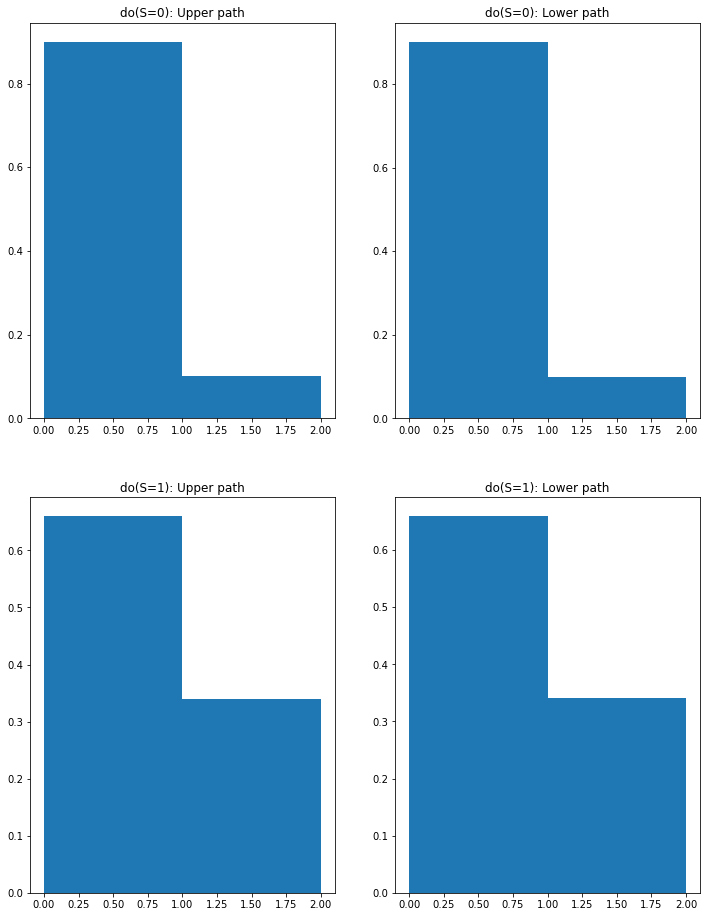

In [43]:
fig,ax = plt.subplots(2,2, figsize=(12,16))

ax[0,0].hist(upper_path_S0,bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('do(S=0): Upper path')

ax[0,1].hist(lower_path_S0,bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('do(S=0): Lower path')

ax[1,0].hist(upper_path_S1,bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('do(S=1): Upper path')

ax[1,1].hist(lower_path_S1,bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('do(S=1): Lower path')

print('Interventional distributions:')
print('do(S=0):')
print('Upper path: P(C=1) = {0}'.format(np.sum(upper_path_S0)/n_samples))
print('Lower path: P(C=1) = {0}'.format(np.sum(lower_path_S0)/n_samples))

print('do(S=1):')
print('Upper path: P(C=1) = {0}'.format(np.sum(upper_path_S1)/n_samples))
print('Lower path: P(C=1) = {0}'.format(np.sum(lower_path_S1)/n_samples))

As guaranteed by the commutativity of the abstraction diagram, the interventional distributions agree.

## Abstraction Error for M1 to M2

Let us move on to quantify the abstraction error $e(\alpha')$ in the more interesting example of $\alpha': \mathcal{M'} \rightarrow \mathcal{M''}$.

By the same analysis as before, we can state that the overall abstraction error is trivially determined by the abstraction error over the only two available variables:
$$
e(\alpha') = E_{\alpha'}(S,C) = \sup_{s \in \mathcal{M'}[S]} \left( \sqrt{ JSD \left( \alpha'_C \circ \mathcal{M'}_{do}[\phi_{C}] , \mathcal{M''}_{do}[\phi_C] \circ \alpha'_S \right)} \right),
$$

This time commutativity does not hold, so we have to compute the supremum. Substituting the numeric values:
$$
E_{\alpha'}(S,C) = 
\sup_{s \in \{0,1\}} \left( \sqrt{ JSD \left( \left[\begin{array}{cc}
	.9 & .1\\
	.66 & .34
	\end{array}\right]
\cdot
\left[\begin{array}{cc}
	1 & 0\\
	0 & 1
	\end{array}\right] , \left[\begin{array}{cc}
	1 & 0\\
	0 & 1
	\end{array}\right]
\cdot
\left[\begin{array}{cc}
	.852 & .148\\
	.852 & .148
	\end{array}\right] \right)} \right)
$$
and simplyfing:
$$
E_{\alpha'}(S,C) = 
\sup_{s \in \{0,1\}} \left( \sqrt{ JSD \left( \left[\begin{array}{cc}
	.9 & .1\\
	.66 & .34
	\end{array}\right], \left[\begin{array}{cc}
	.852 & .148\\
	.852 & .148
	\end{array}\right] \right)} \right)
$$
Notice the meaning of the stochastic matrices we have just introduced: they codify the interventional distribution $P(C \vert do(S=s))$ in the two models (composed with the identity abstraction). Finding the supremum means finding the value $s$ such that the distance between the distributions $P_\mathcal{M'}(C \vert do(S=s))$ and $P_\mathcal{M''}(C \vert do(S=s))$ is maximized. We can then make the argument of the supremum explicit as:
$$
E_{\alpha'}(S,C) = 
\sup \left\{ 
    \sqrt{ JSD \left( 
    \left[\begin{array}{cc}
	.9 & .1
	\end{array}\right], \left[\begin{array}{cc}
	.852 & .148
	\end{array}\right]    
    \right) }, \sqrt{ JSD \left( 
    \left[\begin{array}{cc}
	.66 & .34
	\end{array}\right], \left[\begin{array}{cc}
	.852 & .148
	\end{array}\right]    
    \right) }
    \right\}.
$$
This indeed corresponds to:
$$
E_{\alpha'}(S,C) = 
\sup \left\{ 
    \sqrt{ JSD \left( 
    P_\mathcal{M'}(C \vert do(S=0)), P_\mathcal{M''}(C \vert do(S=0))    
    \right) }, \sqrt{ JSD \left( 
    P_\mathcal{M'}(C \vert do(S=1)), P_\mathcal{M''}(C \vert do(S=1))    
    \right) }
    \right\}.
$$
In more probabilistic terms, we could also express this as:
$$
E_{\alpha'}(S,C) = 
\sup \left\{ 
    \sqrt{ JSD \left( 
    \mathtt{Bern}(.1), \mathtt{Bern}(.148)    
    \right) }, \sqrt{ JSD \left( 
    \mathtt{Bern}(.34), \mathtt{Bern}(.148)   
    \right) }
    \right\}.
$$

We can now compute these two distances, using the function *scipy.spatial.distance.jensenshannon()*, which directly computes $d_{JSD}$:

In [44]:
distance.jensenshannon([.9,.1],[.852,.148])

0.051634404110767126

In [45]:
distance.jensenshannon([.66,.34],[.852,.148])

0.15974085850231165

We can then quantify the abstraction error $e_\alpha \approx 0.16$. In other words, the mechanisms and the abstractions between model $\mathcal{M}'$ and $\mathcal{M}''$ do not commute; choosing one ordering instead of the other could lead to results (in form of an interventional probability distribution) differing (in terms of Jensen-Shannon distance) up to $0.16$.

(**TODO:** verify result. Aprroximation error in [Rischel2020] is 0.085)

### Implementation

Let us now verify the behaviour of the interventional distributions empirically with respect to our second abstraction. 

Let's start considering the upper path in the abstraction diagram; again we need two components:
- a class that implements the intervened model $\mathcal{M'}_{do(S=s)}$ and from which we can compute the application of $\mathcal{M'}_{do}[\phi_{C}]$. We already defined this model above so we will not rewrite it.
- a function implementing the abstraction $\alpha'_C$. This is a simple identity.

In [46]:
def alphap_C(c):
    return c

For the lower path in the abstraction diagram we need the following two components:
- a function implementing the abstraction $\alpha'_S$. This is a simple identity.
- a class that implements the intervened model $\mathcal{M''}_{do(S=\alpha'_S(s))}$ and from which we can compute the application of $\mathcal{M''}_{do}[\phi_{C}]$. We reuse the previous code and reduce the output to $C$.

In [47]:
def alphap_S(s):
    return s

class model2_doS_finstoch():
    def __init__(self,ps=.2):
        self.MphiS = np.array([.8,.2])
        self.MphiC = np.array([.858,.142])
        
    def sample(self,s):
        S = s
        C = scipy.random.binomial(1,self.MphiC[1])        
        return C

We now instantiate the last model.

In [48]:
M2_doS_finstoch = model2_doS_finstoch()

### Simulation

To examine the distributions generated by following the two paths on the abstraction diagram we run our usual Monte Carlo-like simulation collecting $10^6$ samples. We run a set of simulations for the intervention $do(S=0)$ and for the intervention $do(S=1)$. Again, notice how inside the simulation loop the syntax preserves the semantic of the abstraction diagram.

In [49]:
s = 0
upper_path_S0 = np.zeros(n_samples)
lower_path_S0 = np.zeros(n_samples)

for i in tqdm(range(n_samples)):
    upper_path_S0[i] = alphap_C(M1_doS_finstoch.sample(s))
    lower_path_S0[i] = M2_doS_finstoch.sample(alphap_S(s))

s = 1
upper_path_S1 = np.zeros(n_samples)
lower_path_S1 = np.zeros(n_samples)

for i in tqdm(range(n_samples)):
    upper_path_S1[i] = alphap_C(M1_doS_finstoch.sample(s))
    lower_path_S1[i] = M2_doS_finstoch.sample(alphap_S(s))

100%|█████████████████████████████| 1000000/1000000 [00:02<00:00, 337283.49it/s]


Now we can compare the interventional distributions we obtained.

Interventions distributions:
do(S=0):
Upper path: P(C=1) = 0.100342
Lower path: P(C=1) = 0.141491
do(S=1):
Upper path: P(C=1) = 0.339608
Lower path: P(C=1) = 0.142035


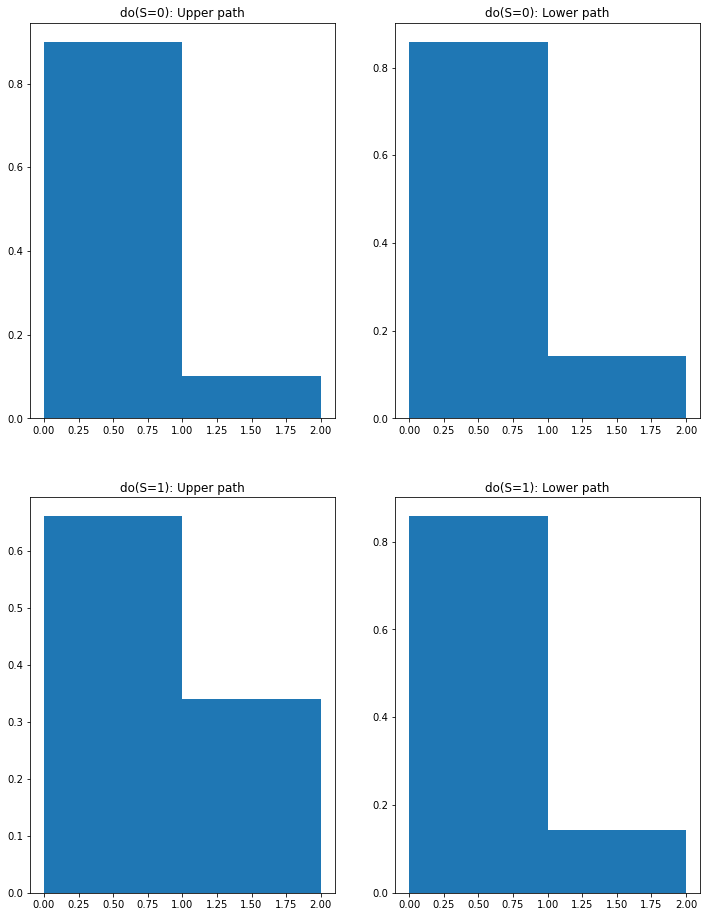

In [50]:
fig,ax = plt.subplots(2,2, figsize=(12,16))

ax[0,0].hist(upper_path_S0,bins=np.array(list(range(3))),density=True)
ax[0,0].set_title('do(S=0): Upper path')

ax[0,1].hist(lower_path_S0,bins=np.array(list(range(3))),density=True)
ax[0,1].set_title('do(S=0): Lower path')

ax[1,0].hist(upper_path_S1,bins=np.array(list(range(3))),density=True)
ax[1,0].set_title('do(S=1): Upper path')

ax[1,1].hist(lower_path_S1,bins=np.array(list(range(3))),density=True)
ax[1,1].set_title('do(S=1): Lower path')

print('Interventions distributions:')
print('do(S=0):')
print('Upper path: P(C=1) = {0}'.format(np.sum(upper_path_S0)/n_samples))
print('Lower path: P(C=1) = {0}'.format(np.sum(lower_path_S0)/n_samples))

print('do(S=1):')
print('Upper path: P(C=1) = {0}'.format(np.sum(upper_path_S1)/n_samples))
print('Lower path: P(C=1) = {0}'.format(np.sum(lower_path_S1)/n_samples))

This time, as predicted by the measure on the abstraction diagram, we observe a mismatch between the interventional distributions.

Further, we can get also an experimental validation of the abstraction error by computing the distance between the empirical distributions we estimated.

In [51]:
p_upper_path = np.histogram(upper_path_S0,bins=np.array(list(range(3))),density=True)[0]
p_lower_path = np.histogram(lower_path_S0,bins=np.array(list(range(3))),density=True)[0]

print('JS distance under intervention do(S=0): {0}'.format(distance.jensenshannon(p_upper_path,p_lower_path)))

p_upper_path = np.histogram(upper_path_S1,bins=np.array(list(range(3))),density=True)[0]
p_lower_path = np.histogram(lower_path_S1,bins=np.array(list(range(3))),density=True)[0]

print('JS distance under intervention do(S=1): {0}'.format(distance.jensenshannon(p_upper_path,p_lower_path)))


JS distance under intervention do(S=0): 0.044718662168915756
JS distance under intervention do(S=1): 0.1652791818132123


## Recap

In this section, we have seen that:

1. **We can enrich the $\mathtt{FinStoch}$ category in $\mathtt{Met}$**: we use JS distance as a metric for the hom-objects.

2. **JS distance is not a necessary candidate**: other metrics could be chosen on $\mathtt{Met}$-$\mathtt{FinStoch}$.

3. **We can use the metric in $\mathtt{Met}$-$\mathtt{FinStoch}$ to quantify the abstraction error between two variables**: we measure the approximation or error introduced by an abstraction between two variables as the worst-case JS distance between interventional probability distributions.

4. **We can use the metric in $\mathtt{Met}$-$\mathtt{FinStoch}$ to quantify the overall approximation error of an abstraction**: we measure the overall approximation or error introduced by an abstraction as the worst-case JS distance between interventional probability distributions between any two pairs of variables.

5. **Zero-error abstractions have null error, approximate abstraction introduce a quantifiable error**.

# Conclusion

In this notebook we have seen an empirical application of the framework proposed in [Rischel2020] to evaluate the abstraction error between two causal models. We have seen how category theory has given us a setup to express causal models and the abstraction relation between them. Moreover, we have seen how enriched categories provided a way to evaluate quantitatively the degree of approximation or error that is introduced by an abstraction mapping a low-level model to a high-level model. The approximation considers the distance between interventional distributions, and thus provide us with a way to assess, in presence of intervention, at what cost we can switch between models at different levels of abstraction.

## Bibliography

[Rischel2020] Rischel, Eigil Fjeldgren. "The Category Theory of Causal Models." (2020).

[Pearl2009] Pearl, Judea. Causality. Cambridge university press, 2009.

[Peters2017] Peters, Jonas, Dominik Janzing, and Bernhard Schölkopf. Elements of causal inference: foundations and learning algorithms. The MIT Press, 2017.

[Spivak2014] Spivak, David I. Category theory for the sciences. MIT Press, 2014.

[Fong2018] Fong, Brendan, and David I. Spivak. "Seven sketches in compositionality: An invitation to applied category theory." arXiv preprint arXiv:1803.05316 (2018).

[Milewski2008] Milewski, B. "[Bartosz Milewski’s Programming Cafe: Enriched Categories](https://bartoszmilewski.com/2017/05/13/enriched-categories/)" (2008). 

[Rubenstein2017] Rubenstein, Paul K., et al. "Causal consistency of structural equation models." arXiv preprint arXiv:1707.00819 (2017).

[Fritz2020] Fritz, Tobias. "A synthetic approach to Markov kernels, conditional independence and theorems on sufficient statistics." Advances in Mathematics 370 (2020): 107239.